<a href="https://colab.research.google.com/github/jglaser/gigadocking_notebooks/blob/main/Gigadocking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Provide your credentials to the runtime

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Declare the Cloud project ID which will be used throughout this notebook

Initially, you'll have to have BigQuery privileges for this project until the datasets are made public.

In [2]:
project_id = 'cmb-covid19-discovery-collab'

## Optional: Enable data table display

Colab includes the ``google.colab.data_table`` package that can be used to display large pandas dataframes as an interactive data table.
It can be enabled with:

In [3]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:
```python
%unload_ext google.colab.data_table
```

# Overview of the docking data sets

First we'll gather some metadata on the available datasets and their sizes

In [ ]:
from google.cloud import bigquery
import pandas as pd
import humanize

# Construct a BigQuery client object.
client = bigquery.Client(project=project_id)

datasets = []
tables = []
sizes = []
all_datasets = list(client.list_datasets()) 
for dataset in all_datasets:
    df = client.query('SELECT table_id, size_bytes FROM {}.__TABLES__'.format(dataset.dataset_id)).to_dataframe()
    cur_tables = list(df.table_id.values)
    tables += cur_tables
    datasets += [dataset.dataset_id for t in cur_tables]
    sizes += list(df.size_bytes)
df = pd.DataFrame({'Dataset': datasets, 'Table': tables, 'Size': sizes})
print('Total size of datasets {}'.format(humanize.naturalsize(df['Size'].sum(),binary=True)))

Total size of datasets 427.4 TiB


In [ ]:
import numpy as np
from google.colab import data_table
from tabulate import tabulate

all_datasets = list(client.list_datasets()) 
df.groupby(['Dataset']).agg({'Size': lambda x: humanize.naturalsize(np.sum(x),binary=True)}).reset_index()

,Dataset,Size
0,enamine_2020q1,246.4 GiB
1,moonshot,234.5 MiB
2,mpro_5r84,116.0 TiB
3,mpro_6wqf,106.0 TiB
4,mpro_exp,90.6 KiB
5,mpro_ncats,904.8 MiB
6,nsp15_6wlc,87.0 TiB
7,plpro,1.4 MiB
8,plpro_7jir,11.8 TiB
9,rdrp,7.2 TiB


Dig deeper into a single dataset to see the tables it contains

In [ ]:
df[df['Dataset']=='mpro_5r84']

,Dataset,Table,Size
15,mpro_5r84,confs_all,79587489885280
16,mpro_5r84,fingerprints,39873826424569
17,mpro_5r84,fingerprints64,5798377272209
18,mpro_5r84,mpro_features,803878791051
19,mpro_5r84,scores,1377859391245
20,mpro_5r84,scores_rank0,123807929088
21,mpro_5r84,top_0001,4425097
22,mpro_5r84,top_150_xgb,41155


Expore the table schemas

In [ ]:
!bq show --project_id $project_id plpro_7jir.confs_all


Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
  #            projectId                     friendlyName          
 --- ------------------------------ ------------------------------ 
  1   cmb-covid19-discovery-collab   cmb-covid19-discovery-collab  
Found only one project, setting cmb-covid19-discovery-collab as the default.

BigQuery configuration complete! Type "bq" to get started.

Table cmb-covid19-discovery-collab:plpro_7jir.confs_all

   Last modified               Schema               Total Rows    Total Bytes     Expiration   Time Partitioning   Clustered Fields   Labels  
 ----------------- ------------------------------- ------------ ---------------- ------------ ------------------- ------------------ -------- 
  14 Feb 21:58:06   |- name: st

# Query a dataset to return top scores

We'll issue our SQL queries through iPython magics, which runs a query and either displays the result or saves it to a variable as a `DataFrame`.

In [ ]:
# Display query output immediately

%%bigquery --project $project_id
SELECT * FROM mpro_5r84.scores
ORDER BY rf2 DESC LIMIT 200

,name,rank,score,rf2,vs_dude_v2,dcoid
0,Z1785895966_1_T1,5,-6.37,8.527695,6.240727,0.516
1,PV-001938484367_1_T1,8,-6.00,8.437683,6.182937,0.488
2,PV-001915805464_1_T1,19,-5.07,8.403433,6.200973,0.542
3,PV-001842084659_1_T1,3,-7.97,8.359284,6.126051,0.500
4,Z1744525712_2_T1,15,-7.12,8.332914,6.172450,0.476
...,...,...,...,...,...,...
195,PV-001915403326_1_T1,0,-5.99,8.139894,6.157118,0.518
196,PV-001915941453_1_T1,0,-9.76,8.139838,6.031066,0.406
197,PV-002017760997_1_T1,1,-7.77,8.139808,6.083212,0.580
198,Z1151180463_2_T1,1,-9.86,8.139525,6.151793,0.382


In [ ]:
# Save output in a variable `df`

%%bigquery --project $project_id df
SELECT * FROM mpro_5r84.scores
ORDER BY rf2 DESC LIMIT 100

In [ ]:
df

,name,rank,score,rf2,vs_dude_v2,dcoid
0,Z1785895966_1_T1,5,-6.37,8.527695,6.240727,0.516
1,PV-001938484367_1_T1,8,-6.00,8.437683,6.182937,0.488
2,PV-001915805464_1_T1,19,-5.07,8.403433,6.200973,0.542
3,PV-001842084659_1_T1,3,-7.97,8.359284,6.126051,0.500
4,Z1744525712_2_T1,15,-7.12,8.332914,6.172450,0.476
...,...,...,...,...,...,...
95,PV-001850722983_1_T1,7,-5.65,8.167635,6.142249,0.254
96,Z1908699407_2_T3,7,-8.46,8.167416,6.018709,0.310
97,Z2720022241_3_T2,11,-6.59,8.167158,6.055740,0.122
98,Z2964299579_1_T1,10,-6.25,8.166935,6.098409,0.180


# Plot correlation matrix of polar and hydrophobic contacts

In [4]:
%%bigquery --project $project_id df
SELECT * FROM mpro_5r84.mpro_features LIMIT 10

In [5]:
import numpy as np
columns = sorted(np.unique(['_'.join(c.split('_')[:2]) for c in df.columns if c != 'name' and c != '__null_dask_index__']), key=lambda x: int(x.split('_')[1]))

In [10]:
%%bigquery --project $project_id df
SELECT * FROM moonshot.mpro_features LIMIT 10

In [11]:
import numpy as np
columns_new = sorted(np.unique(['_'.join(c.split('_')[:2]) for c in df.columns if c != 'string_field_0']), key=lambda x: int(x.split('_')[1]))

In [ ]:
%%time
q = "SELECT " + ", ".join(['CORR({}_AB,{}_AB)'.format(ci,cj) for ci in columns for cj in columns]) + \
    " FROM mpro_5r84.mpro_features"
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_corr = client.query(q).to_dataframe()

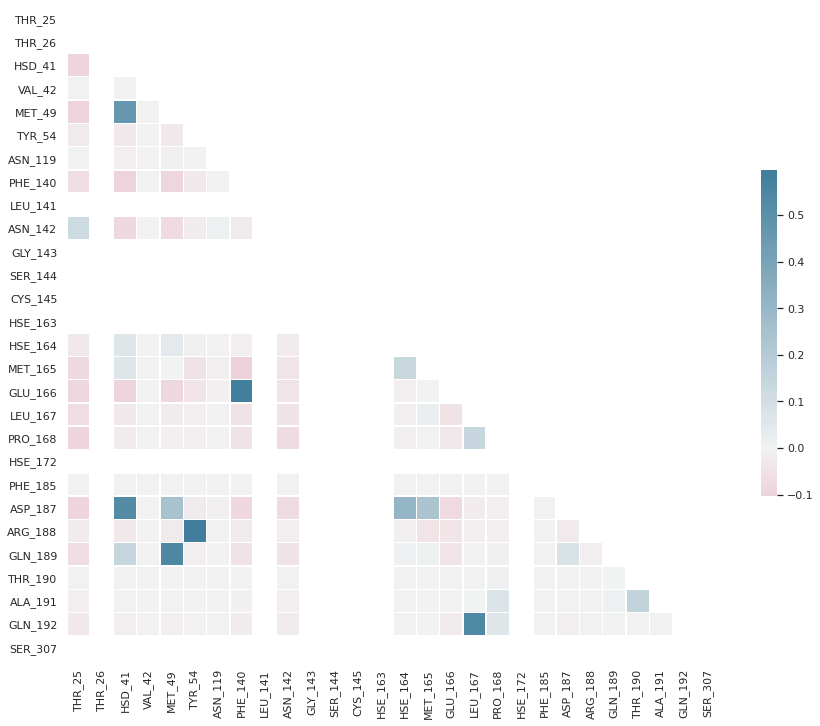

In [ ]:
corr = df_corr.transpose()
corr = corr.set_index(pd.MultiIndex.from_product([columns,columns]))#, names=["i", "j"]))
corr = corr[0].unstack().reindex(columns)[columns]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(0, 230, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
%%time
q = "SELECT " + ", ".join(['CORR({}_AB,{}_AB)'.format(ci,cj) for ci in columns_moonshot for cj in columns_moonshot]) + \
    """ FROM moonshot.mpro_features
    INNER JOIN moonshot.activities ON activities.CID = mpro_features.string_field_0
    """
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_corr_moonshot = client.query(q).to_dataframe()

CPU times: user 239 ms, sys: 5.94 ms, total: 245 ms
Wall time: 2.3 s


In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*) FROM moonshot.mpro_features
    INNER JOIN moonshot.activities ON activities.CID = mpro_features.string_field_0


,f0_
0,277


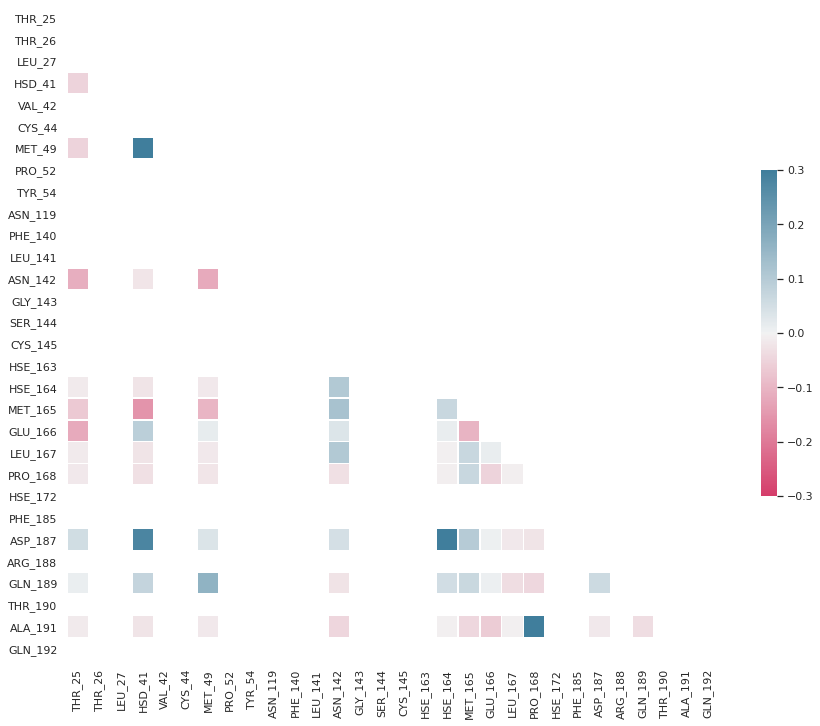

In [ ]:
corr_moonshot = df_corr_moonshot.transpose()
corr_moonshot = corr_moonshot.set_index(pd.MultiIndex.from_product([columns_moonshot,columns_moonshot]))#, names=["i", "j"]))
corr_moonshot = corr_moonshot[0].unstack().reindex(columns_moonshot)[columns_moonshot]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(0, 230, as_cmap=True)
mask = np.triu(np.ones_like(corr_moonshot, dtype=bool))
sns.heatmap(corr_moonshot, mask=mask, cmap=cmap, center=0, vmax=0.3, vmin=-0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
%%time
q = "SELECT " + ", ".join(['CORR({}_AB,{}_AB)'.format(ci,cj) for ci in columns for cj in columns]) + \
    """ FROM moonshot.mpro_features_redocked_fix_charge
    INNER JOIN moonshot.diamond_compound_tracker ON diamond_compound_tracker.`Compound_ID` = mpro_features_redocked_fix_charge.name
    WHERE diamond_compound_tracker.Dataset IS NOT NULL
    AND mpro_features_redocked_fix_charge.`rank` = 0
    """
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_corr_moonshot_apolar_redocked = client.query(q).to_dataframe()

CPU times: user 182 ms, sys: 5.58 ms, total: 187 ms
Wall time: 1.71 s


In [ ]:
%%bigquery --project $project_id
SELECT COUNT(*) FROM moonshot.mpro_features_redocked_fix_charge
    INNER JOIN moonshot.diamond_compound_tracker ON diamond_compound_tracker.`Compound_ID` = mpro_features_redocked_fix_charge.name
    WHERE diamond_compound_tracker.Dataset IS NOT NULL
    AND mpro_features_redocked_fix_charge.`rank` = 0

,f0_
0,280


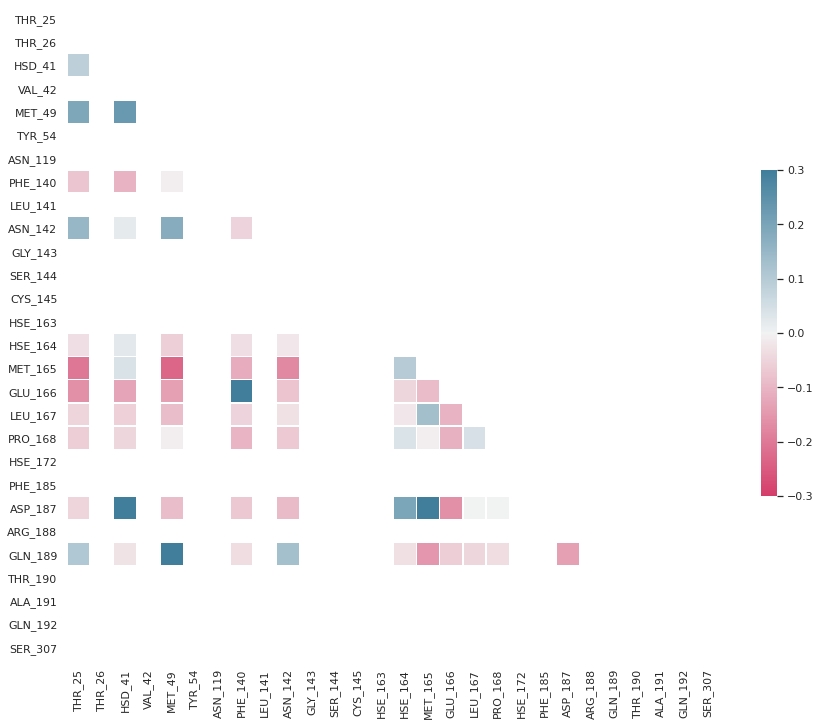

In [ ]:
corr_moonshot = df_corr_moonshot_apolar_redocked.transpose()
corr_moonshot = corr_moonshot.set_index(pd.MultiIndex.from_product([columns,columns]))#, names=["i", "j"]))
corr_moonshot = corr_moonshot[0].unstack().reindex(columns)[columns]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(0, 230, as_cmap=True)
mask = np.triu(np.ones_like(corr_moonshot, dtype=bool))
sns.heatmap(corr_moonshot, mask=mask, cmap=cmap, center=0, vmax=0.3, vmin=-0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
%%time
q = "SELECT " + ", ".join(['CORR({}_PB,{}_PB)'.format(ci,cj) for ci in columns_moonshot for cj in columns_moonshot]) + \
    """ FROM moonshot.mpro_features
    INNER JOIN moonshot.activities ON activities.CID = mpro_features.string_field_0
    """
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_corr_moonshot_polar = client.query(q).to_dataframe()

CPU times: user 189 ms, sys: 6.44 ms, total: 195 ms
Wall time: 2.62 s


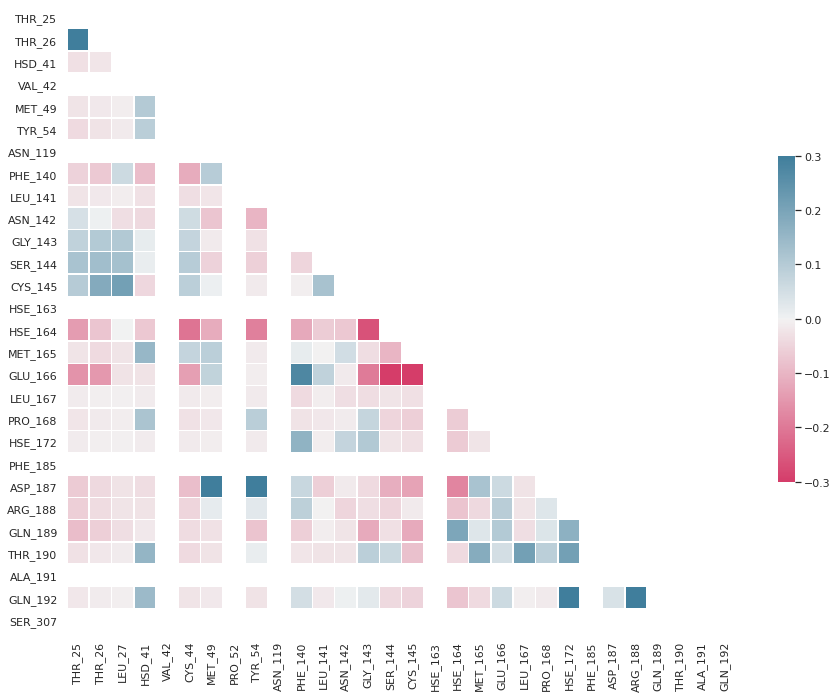

In [ ]:
corr_moonshot = df_corr_moonshot_polar.transpose()
corr_moonshot = corr_moonshot.set_index(pd.MultiIndex.from_product([columns_moonshot,columns_moonshot]))#, names=["i", "j"]))
corr_moonshot = corr_moonshot[0].unstack().reindex(columns)[columns_moonshot]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(0, 230, as_cmap=True)
mask = np.triu(np.ones_like(corr_moonshot, dtype=bool))
sns.heatmap(corr_moonshot, mask=mask, cmap=cmap, center=0, vmin=-0.3, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
%%time
q = "SELECT " + ", ".join(['AVG({}_PB)'.format(c) for c in columns]) + \
    " FROM moonshot.mpro_features_redocked WHERE rank = 0"
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_avg_contacts_redocked = client.query(q).to_dataframe()

CPU times: user 45.2 ms, sys: 1.72 ms, total: 46.9 ms
Wall time: 1.52 s


In [56]:
%%bigquery --project=$project_id
SELECT COUNT(*) FROM  moonshot.mpro_features_redocked WHERE rank = 0

,f0_
0,1688


In [6]:
%%time
q = "SELECT " + ", ".join(['AVG({}_PB)'.format(c) for c in columns]) + """FROM mpro_5r84.mpro_features
    INNER JOIN mpro_5r84.scores_rank0 ON mpro_features.name = scores_rank0.name"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_avg_contacts = client.query(q).to_dataframe()

CPU times: user 222 ms, sys: 21.4 ms, total: 244 ms
Wall time: 38.3 s


In [12]:
%%time
q = "SELECT " + ", ".join(['AVG({}_PB)'.format(c) for c in columns_new]) + \
    " FROM moonshot.mpro_features"
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_avg_contacts_moonshot = client.query(q).to_dataframe()

CPU times: user 45.2 ms, sys: 4.96 ms, total: 50.2 ms
Wall time: 1.13 s


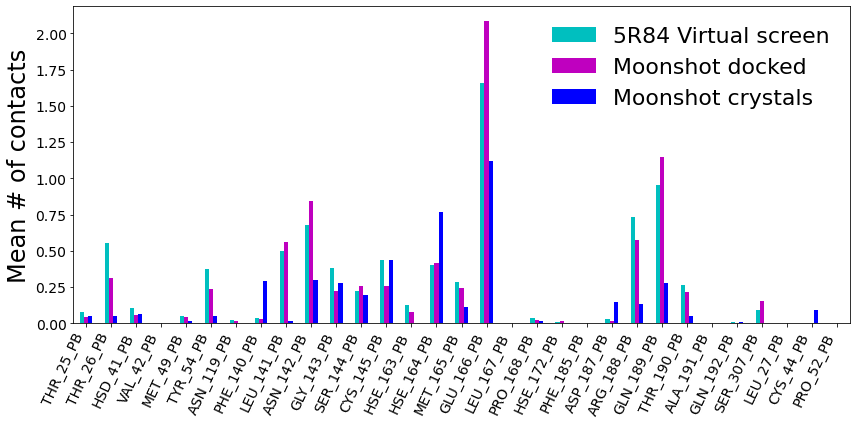

In [61]:
import pandas as pd
df1 = df_avg_contacts.transpose().set_index(pd.Index(['{}_PB'.format(c) for c in columns]))
df2 = df_avg_contacts_redocked.transpose().set_index(pd.Index(['{}_PB'.format(c) for c in columns]))
df3 = df_avg_contacts_moonshot.transpose().set_index(pd.Index(['{}_PB'.format(c) for c in columns_new]))
df = pd.concat([df1.T,df2.T,df3.T]).reset_index(drop=True).T
df = df.rename(columns={0: '5R84 Virtual screen', 1: 'Moonshot docked', 2: 'Moonshot crystals'})
ax = df.plot.bar(color=['c','m','b'])
ax.figure.set_size_inches(12,6)
ax.tick_params('x',labelsize=14,rotation=65)
ax.set_xticklabels(ax.get_xticklabels(),ha='right')
ax.tick_params('y',labelsize=14)
ax.set_ylabel("Mean # of contacts",fontsize=24)
ax.legend(frameon=False, fontsize=22)
ax.figure.tight_layout()
ax.figure.savefig('avg_contacts.pdf')

In [62]:
from google.colab import files
files.download('avg_contacts.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time
q = "SELECT " + ", ".join(['CORR({}_PB,{}_PB)'.format(ci,cj) for ci in columns for cj in columns]) + \
    """ FROM moonshot.mpro_features_redocked_5R84_01
    INNER JOIN moonshot.diamond_compound_tracker ON diamond_compound_tracker.`Compound_ID` = mpro_features_redocked_5R84_01.name
    WHERE diamond_compound_tracker.Dataset IS NOT NULL
    AND mpro_features_redocked_5R84_01.`rank` = 0
    """
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_corr_moonshot_polar_redocked = client.query(q).to_dataframe()

CPU times: user 284 ms, sys: 6.59 ms, total: 291 ms
Wall time: 4.19 s


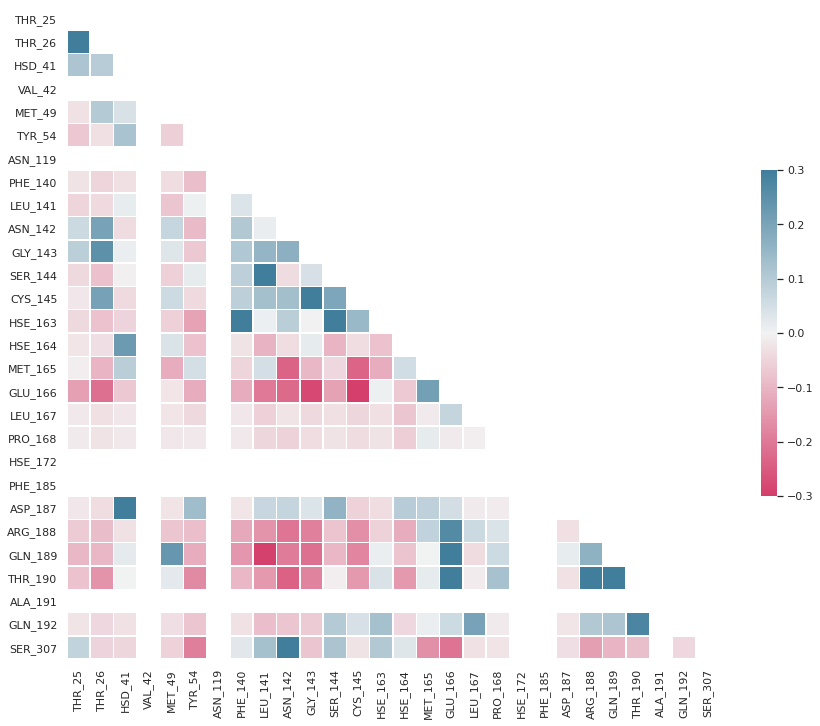

In [ ]:
corr_moonshot = df_corr_moonshot_polar_redocked.transpose()
corr_moonshot = corr_moonshot.set_index(pd.MultiIndex.from_product([columns,columns]))#, names=["i", "j"]))
corr_moonshot = corr_moonshot[0].unstack().reindex(columns)[columns]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(0, 230, as_cmap=True)
mask = np.triu(np.ones_like(corr_moonshot, dtype=bool))
sns.heatmap(corr_moonshot, mask=mask, cmap=cmap, center=0, vmin=-0.3,vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM moonshot.mpro_features_redocked_6wqf LIMIT 10

In [ ]:
import numpy as np
columns_6wqf = sorted(np.unique(['_'.join(c.split('_')[:2]) for c in df.columns if c != 'name' and c != 'rank']), key=lambda x: int(x.split('_')[1]))

In [ ]:
%%time
q = "SELECT " + ", ".join(['CORR({}_PB,{}_PB)'.format(ci,cj) for ci in columns_6wqf for cj in columns_6wqf]) + \
    """ FROM moonshot.mpro_features_redocked_6wqf
    INNER JOIN moonshot.diamond_compound_tracker ON diamond_compound_tracker.`Compound_ID` = mpro_features_redocked_6wqf.name
    WHERE diamond_compound_tracker.Dataset IS NOT NULL
    AND mpro_features_redocked_6wqf.`rank` = 0
    """
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_corr_moonshot_polar_redocked_6wqf = client.query(q).to_dataframe()

CPU times: user 171 ms, sys: 3.64 ms, total: 175 ms
Wall time: 1.53 s


In [ ]:
df_corr_moonshot_polar_redocked_6wqf

,f0_,f1_,f2_,f3_,f4_,f5_,f6_,f7_,f8_,f9_,f10_,f11_,f12_,f13_,f14_,f15_,f16_,f17_,f18_,f19_,f20_,f21_,f22_,f23_,f24_,f25_,f26_,f27_,f28_,f29_,f30_,f31_,f32_,f33_,f34_,f35_,f36_,f37_,f38_,f39_,...,f689_,f690_,f691_,f692_,f693_,f694_,f695_,f696_,f697_,f698_,f699_,f700_,f701_,f702_,f703_,f704_,f705_,f706_,f707_,f708_,f709_,f710_,f711_,f712_,f713_,f714_,f715_,f716_,f717_,f718_,f719_,f720_,f721_,f722_,f723_,f724_,f725_,f726_,f727_,f728_
0,1.0,0.352996,0.305344,NaN,0.104261,NaN,0.090724,-0.165518,0.072803,0.135027,0.080896,-0.028145,0.069124,-0.156102,-0.062275,-0.078432,-0.315651,-0.078497,-0.00007,-0.028702,NaN,NaN,-0.17509,-0.08608,-0.246146,-0.020259,-0.173646,0.352996,1.0,0.065695,NaN,0.11033,NaN,0.685767,-0.130793,-0.084197,0.514754,0.448848,-0.054851,0.005027,...,-0.022845,-0.001536,0.005001,-0.013888,-0.01396,-0.005078,NaN,NaN,0.053232,0.040982,0.133231,1.0,0.100884,-0.173646,-0.181415,-0.141722,NaN,0.068261,NaN,-0.107611,-0.261545,-0.155907,-0.2592,-0.197374,-0.14379,-0.165428,-0.382671,-0.039617,-0.067116,-0.215483,-0.037615,-0.018721,-0.046739,NaN,NaN,0.357413,0.014441,0.645877,0.100884,1.0


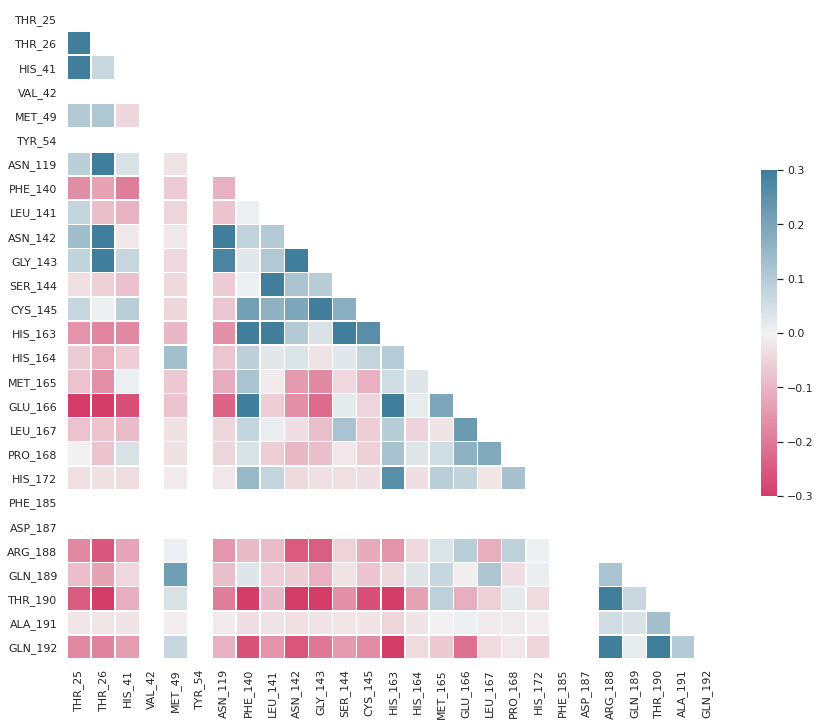

In [ ]:
corr_moonshot = df_corr_moonshot_polar_redocked_6wqf.transpose()
corr_moonshot = corr_moonshot.set_index(pd.MultiIndex.from_product([columns_6wqf,columns_6wqf]))#, names=["i", "j"]))
corr_moonshot = corr_moonshot[0].unstack().reindex(columns_6wqf)[columns_6wqf]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(0, 230, as_cmap=True)
mask = np.triu(np.ones_like(corr_moonshot, dtype=bool))
sns.heatmap(corr_moonshot, mask=mask, cmap=cmap, center=0, vmin=-0.3,vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
%%time
q = "SELECT " + ", ".join(['CORR({}_PB,{}_PB)'.format(ci,cj) for ci in columns for cj in columns]) + \
    " FROM mpro_5r84.mpro_features"
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_corr_polar = client.query(q).to_dataframe()

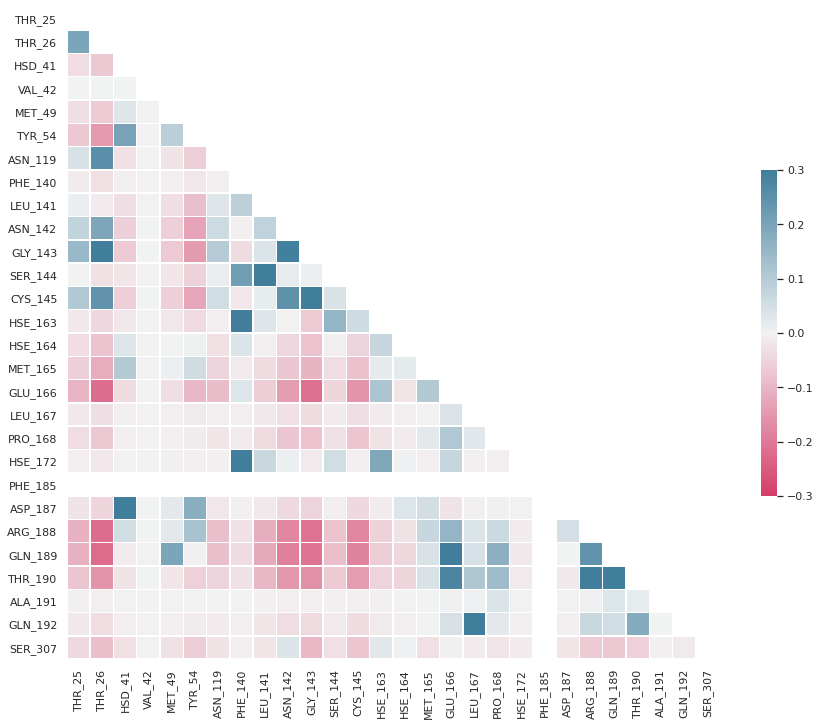

In [ ]:
import pandas as pd
corr = df_corr_polar.transpose()
corr = corr.set_index(pd.MultiIndex.from_product([columns,columns]))#, names=["i", "j"]))
corr = corr[0].unstack().reindex(columns)[columns]

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(0, 230, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, vmin=-0.3, vmax=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#Histogram of XGBoost scores
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 0.0001
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(predicted_active_probs[OFFSET(0)].prob/{})*{} AS bucket_floor FROM 
          ML.PREDICT(MODEL `moonshot.xgbmodel`, TABLE mpro_5r84.mpro_features) AS A
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(bin_width,bin_width)
df_hist = client.query(q).to_dataframe()

In [ ]:
# #Histogram of XGBoost scores
# from google.cloud import bigquery

# client = bigquery.Client(project=project_id)
# bin_width = 0.0001
# q = """
# SELECT bucket_floor, COUNT(*) as bincount
# FROM (
#         SELECT floor(predicted_active_probs[OFFSET(0)].prob/{})*{} AS bucket_floor FROM 
#           ML.PREDICT(MODEL `moonshot.xgbmodel`, TABLE mpro_5r84.mpro_features)
#           LIMIT 1000000
#       )
# GROUP BY bucket_floor
# ORDER BY bucket_floor""".format(bin_width,bin_width)
# df_hist = client.query(q).to_dataframe()

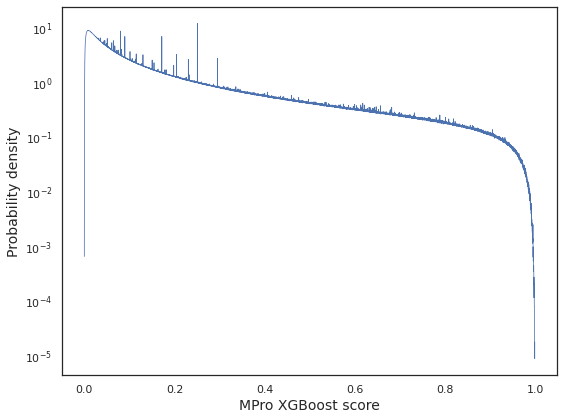

In [ ]:
df_hist['hist_norm'] = df_hist.bincount/df_hist.bincount.sum()/bin_width
ax = df_hist.plot(x="bucket_floor",y="hist_norm",ms=0.5,linewidth=0.75,legend=None)
ax.set_xlabel("MPro XGBoost score",fontsize=14)
ax.set_ylabel("Probability density",fontsize=14)
ax.set_yscale('log')
fig = ax.get_figure()
fig.set_size_inches(8,6)
fig.tight_layout()

In [ ]:
%%bigquery --project $project_id df_xgboost
SELECT name, __residual_activity, predicted_active_probs[OFFSET(0)].prob AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
  (SELECT A.*, exp.__residual_activity FROM mpro_5r84.mpro_features AS A
   INNER JOIN mpro_exp.primary_screen_sep_2020 AS exp
   ON A.name = exp.name))
ORDER BY xgb_score DESC
LIMIT 1000

Text(0, 0.5, '% residual activity')

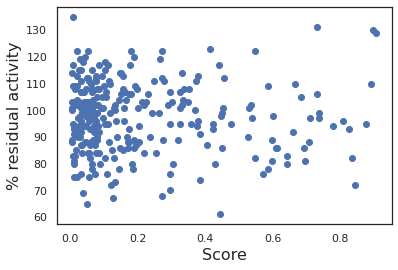

In [ ]:
fig, ax = plt.subplots()
x = df_xgboost.xgb_score
y = df_xgboost.__residual_activity
ax.scatter(x,y)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("% residual activity",fontsize=16)

In [ ]:
%%bigquery --project $project_id df_xgboost
SELECT name, __residual_activity, predicted_active_probs[OFFSET(0)].prob AS xgb_score
FROM ML.PREDICT(MODEL `moonshot.xgbmodel`,
  (SELECT A.*, exp.__residual_activity FROM mpro_5r84.mpro_features AS A
   INNER JOIN mpro_exp.hit_expansion AS exp
   ON STARTS_WITH(A.name,exp.Inhibitor)))
ORDER BY xgb_score DESC

Text(0, 0.5, 'residual activity')

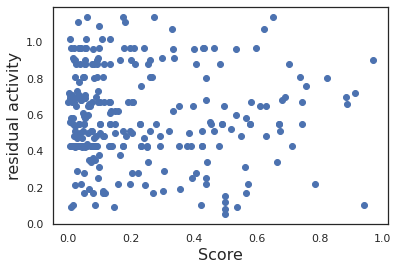

In [ ]:
fig, ax = plt.subplots()
x = df_xgboost.xgb_score
y = df_xgboost.__residual_activity
ax.scatter(x,y)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("residual activity",fontsize=16)

In [ ]:
%%bigquery --project $project_id df_score
SELECT name, __residual_activity, score, rf2, vs_dude_v2
FROM mpro_5r84.scores
   INNER JOIN mpro_exp.hit_expansion AS exp
   ON STARTS_WITH(name,exp.Inhibitor)
WHERE rank = 0
ORDER BY __residual_activity ASC

In [ ]:
fig, ax = plt.subplots()
x = df_score.score
y = df_score.__residual_activity
ax.scatter(x,y)
ax.set_xlabel("Score",fontsize=16)
ax.set_ylabel("residual activity",fontsize=16)

NameError: ignored

## Contacts in the binding pocket

In [ ]:
! curl -o map.csv https://raw.githubusercontent.com/jglaser/gigadocking_notebooks/main/site_contacts/map.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6440  100  6440    0     0   123k      0 --:--:-- --:--:-- --:--:--  123k


In [ ]:
import pandas as pd
map = pd.read_csv('map.csv')

In [ ]:
# Arrays with the residue name and id for each site
S1p_res = [n+"_"+str(i) for n, i in np.unique(list(zip(map[ map['site'] == 'S1p']['res_name'].values,map[ map['site'] == 'S1p']['res_num'].values)),axis=0)]
S1_res = [n+"_"+str(i) for n, i in np.unique(list(zip(map[ map['site'] == 'S1']['res_name'].values,map[ map['site'] == 'S1']['res_num'].values)),axis=0)]
S2_res = [n+"_"+str(i) for n, i in np.unique(list(zip(map[ map['site'] == 'S2']['res_name'].values,map[ map['site'] == 'S2']['res_num'].values)),axis=0)]
S3_res = [n+"_"+str(i) for n, i in np.unique(list(zip(map[ map['site'] == 'S3']['res_name'].values,map[ map['site'] == 'S3']['res_num'].values)),axis=0)]
S45_res = [n+"_"+str(i) for n, i in np.unique(list(zip(map[ map['site'] == 'S4-S5']['res_name'].values,map[ map['site'] == 'S4-S5']['res_num'].values)),axis=0)]

In [ ]:
S1p_res, S1_res, S2_res, S3_res, S45_res

(['ASN_119', 'GLY_143', 'THR_25', 'THR_26', 'VAL_42'],
 ['ASN_142',
  'CYS_145',
  'GLU_166',
  'GLY_143',
  'HSE_163',
  'HSE_164',
  'HSE_172',
  'LEU_141',
  'MET_165',
  'PHE_140',
  'SER_144',
  'SER_307'],
 ['ARG_188', 'ASP_187', 'HSD_41', 'HSE_164', 'MET_49', 'TYR_54'],
 ['GLN_189', 'GLN_192', 'GLU_166', 'LEU_167', 'MET_165', 'THR_190'],
 ['ALA_191', 'ARG_188', 'GLN_189', 'PHE_185', 'PRO_168', 'THR_190'])

### S1

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S1_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S1_bad = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S1_res]+[r+'_AB' for r in S1_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S1_good = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S1_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S1_bad = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S1_res]+[r+'_AB' for r in S1_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S1_good = client.query(q).to_dataframe()

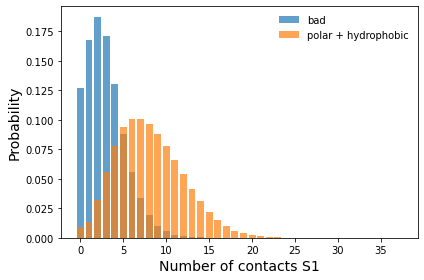

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_hist_S1_bad['hist_norm'] = df_hist_S1_bad.bincount/df_hist.bincount.sum()/bin_width
df_hist_S1_good['hist_norm'] = df_hist_S1_good.bincount/df_hist.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_hist_S1_bad['bucket_floor']
y = df_hist_S1_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_hist_S1_good['bucket_floor']
y = df_hist_S1_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("Number of contacts S1",fontsize=14)
ax.set_ylabel("Probability",fontsize=14)
xticks = np.arange(0,df_hist_S1_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

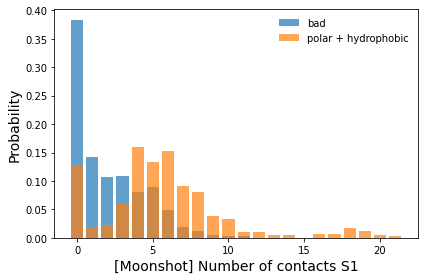

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_moonshot_S1_bad['hist_norm'] = df_moonshot_S1_bad.bincount/df_moonshot_S1_bad.bincount.sum()/bin_width
df_moonshot_S1_good['hist_norm'] = df_moonshot_S1_good.bincount/df_moonshot_S1_good.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_moonshot_S1_bad['bucket_floor']
y = df_moonshot_S1_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_moonshot_S1_good['bucket_floor']
y = df_moonshot_S1_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("[Moonshot] Number of contacts S1",fontsize=14)
ax.set_ylabel("Probability",fontsize=14)
xticks = np.arange(0,df_moonshot_S1_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

### S1prime

In [ ]:
#Histogram of XGBoost scores
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S1p_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S1p_bad = client.query(q).to_dataframe()

In [ ]:
#Histogram of XGBoost scores
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S1p_res]+[r+'_AB' for r in S1p_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S1p_good = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S1p_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S1p_bad = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S1p_res]+[r+'_AB' for r in S1p_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S1p_good = client.query(q).to_dataframe()

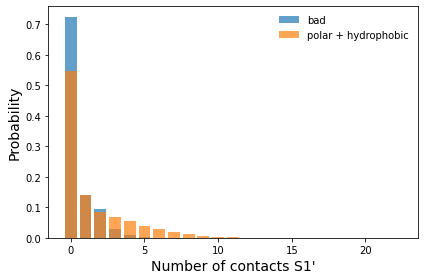

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_hist_S1p_bad['hist_norm'] = df_hist_S1p_bad.bincount/df_hist_S1p_bad.bincount.sum()/bin_width
df_hist_S1p_good['hist_norm'] = df_hist_S1p_good.bincount/df_hist_S1p_good.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_hist_S1p_bad['bucket_floor']
y = df_hist_S1p_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_hist_S1p_good['bucket_floor']
y = df_hist_S1p_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("Number of contacts S1'",fontsize=14)
ax.set_ylabel("Probability",fontsize=14)
xticks = np.arange(0,df_hist_S1p_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

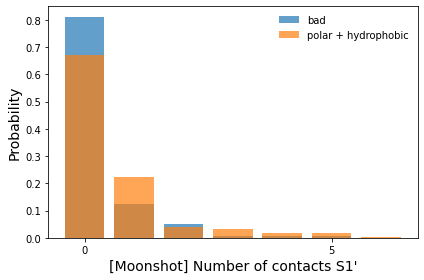

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_moonshot_S1p_bad['hist_norm'] = df_moonshot_S1p_bad.bincount/df_moonshot_S1p_bad.bincount.sum()/bin_width
df_moonshot_S1p_good['hist_norm'] = df_moonshot_S1p_good.bincount/df_moonshot_S1p_good.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_moonshot_S1p_bad['bucket_floor']
y = df_moonshot_S1p_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_moonshot_S1p_good['bucket_floor']
y = df_moonshot_S1p_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("[Moonshot] Number of contacts S1'",fontsize=14)
ax.set_ylabel("Probability",fontsize=14)
xticks = np.arange(0,df_moonshot_S1p_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

### S2

In [ ]:
#Histogram of XGBoost scores
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S2_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S2_bad = client.query(q).to_dataframe()

In [ ]:
#Histogram of XGBoost scores
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S2_res]+[r+'_AB' for r in S2_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S2_good = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S2_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S2_bad = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S2_res]+[r+'_AB' for r in S2_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S2_good = client.query(q).to_dataframe()

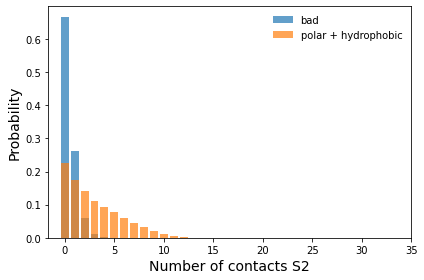

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_hist_S2_bad['hist_norm'] = df_hist_S2_bad.bincount/df_hist_S2_bad.bincount.sum()/bin_width
df_hist_S2_good['hist_norm'] = df_hist_S2_good.bincount/df_hist_S2_bad.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_hist_S2_bad['bucket_floor']
y = df_hist_S2_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_hist_S2_good['bucket_floor']
y = df_hist_S2_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("Number of contacts S2",fontsize=14)
ax.set_ylabel("Probability",fontsize=14)
xticks = np.arange(0,df_hist_S1_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

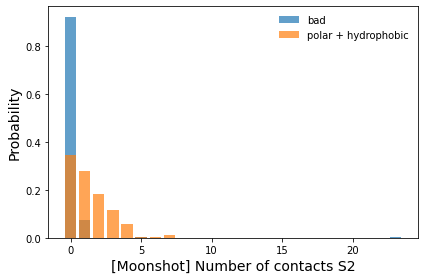

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_moonshot_S2_bad['hist_norm'] = df_moonshot_S2_bad.bincount/df_moonshot_S2_bad.bincount.sum()/bin_width
df_moonshot_S2_good['hist_norm'] = df_moonshot_S2_good.bincount/df_moonshot_S2_good.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_moonshot_S2_bad['bucket_floor']
y = df_moonshot_S2_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_moonshot_S2_good['bucket_floor']
y = df_moonshot_S2_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("[Moonshot] Number of contacts S2",fontsize=14)
ax.set_ylabel("Probability",fontsize=14)
xticks = np.arange(0,df_moonshot_S2_bad['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

### S3

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S3_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S3_bad = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S3_res]+[r+'_AB' for r in S3_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S3_good = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S3_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S3_bad = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S3_res]+[r+'_AB' for r in S3_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S3_good = client.query(q).to_dataframe()

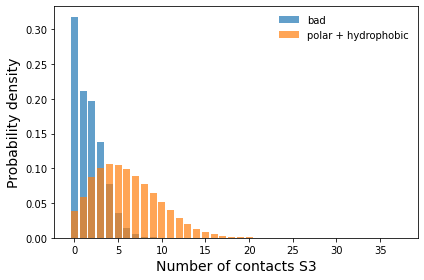

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_hist_S3_bad['hist_norm'] = df_hist_S3_bad.bincount/df_hist_S3_bad.bincount.sum()/bin_width
df_hist_S3_good['hist_norm'] = df_hist_S3_good.bincount/df_hist_S3_good.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_hist_S3_bad['bucket_floor']
y = df_hist_S3_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_hist_S3_good['bucket_floor']
y = df_hist_S3_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("Number of contacts S3",fontsize=14)
ax.set_ylabel("Probability density",fontsize=14)
xticks = np.arange(0,df_hist_S3_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

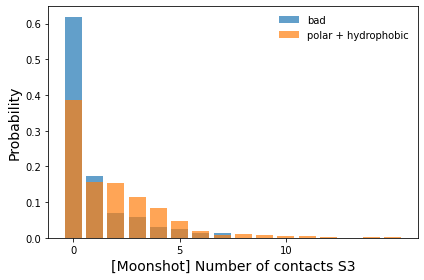

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_moonshot_S3_bad['hist_norm'] = df_moonshot_S3_bad.bincount/df_moonshot_S3_bad.bincount.sum()/bin_width
df_moonshot_S3_good['hist_norm'] = df_moonshot_S3_good.bincount/df_moonshot_S3_good.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_moonshot_S3_bad['bucket_floor']
y = df_moonshot_S3_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_moonshot_S3_good['bucket_floor']
y = df_moonshot_S3_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("[Moonshot] Number of contacts S3",fontsize=14)
ax.set_ylabel("Probability",fontsize=14)
xticks = np.arange(0,df_moonshot_S3_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

### S4-5

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S45_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S45_bad = client.query(q).to_dataframe()

In [ ]:
#Histogram of XGBoost scores
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S45_res]+[r+'_AB' for r in S45_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          mpro_5r84.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_hist_S45_good = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1
columns = '+'.join([r+'_tr' for r in S45_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S45_bad = client.query(q).to_dataframe()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 1.0
columns = '+'.join([r+'_PB' for r in S3_res]+[r+'_AB' for r in S45_res])
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(({})/{})*{} AS bucket_floor FROM 
          moonshot.mpro_features
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(columns,bin_width,bin_width)
df_moonshot_S45_good = client.query(q).to_dataframe()

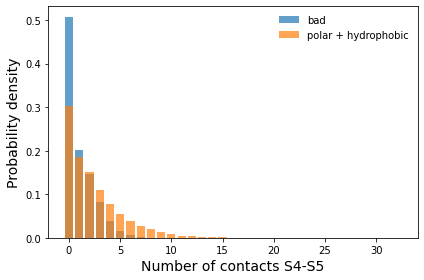

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_hist_S45_bad['hist_norm'] = df_hist_S45_bad.bincount/df_hist_S45_bad.bincount.sum()/bin_width
df_hist_S45_good['hist_norm'] = df_hist_S45_good.bincount/df_hist_S45_good.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_hist_S45_bad['bucket_floor']
y = df_hist_S45_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_hist_S45_good['bucket_floor']
y = df_hist_S45_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("Number of contacts S4-S5",fontsize=14)
ax.set_ylabel("Probability density",fontsize=14)
xticks = np.arange(0,df_hist_S45_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

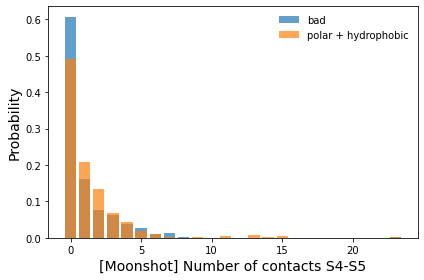

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
df_moonshot_S45_bad['hist_norm'] = df_moonshot_S45_bad.bincount/df_moonshot_S45_bad.bincount.sum()/bin_width
df_moonshot_S45_good['hist_norm'] = df_moonshot_S45_good.bincount/df_moonshot_S45_good.bincount.sum()/bin_width

fig, ax = plt.subplots()
x = df_moonshot_S45_bad['bucket_floor']
y = df_moonshot_S45_bad['hist_norm']
ax.bar(x,y,label='bad',alpha=.7)
x = df_moonshot_S45_good['bucket_floor']
y = df_moonshot_S45_good['hist_norm']
ax.bar(x,y,label='polar + hydrophobic',alpha=0.7)
#ax.figure.set_size_inches(6,6)
ax.set_xlabel("[Moonshot] Number of contacts S4-S5",fontsize=14)
ax.set_ylabel("Probability",fontsize=14)
xticks = np.arange(0,df_moonshot_S45_good['bucket_floor'].max(),5).astype(np.int32)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(frameon=False)
fig.tight_layout()

# Extract PDBs for top compounds by joining two tables

Query the top compounds and their conformations as PDBQT's

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM mpro_5r84.confs_all
INNER JOIN (
  SELECT * FROM mpro_5r84.scores_rank0 ORDER BY rf3 DESC LIMIT 100
) AS top
ON (confs_all.name = top.name)
WHERE (confs_all.rank = 0)


Install some cheminformatics packages (takes a few minutes)


In [ ]:
# see https://colab.research.google.com/drive/12pdvG99aij2put7o_QX-aw3MkRWdZa2g#scrollTo=y2IaxgQ5hAZx
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda create -y -n py37 python=3.7 
!time conda install -n py37 -q -y -c conda-forge rdkit
!time conda install -n py37 -q -y -c conda-forge openbabel
!time pip install py3dmol
import sys
import os
sys.path.append('/usr/local/envs/py37/lib/python3.7/site-packages/')

--2021-02-15 04:49:38--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2021-02-15 04:49:38--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  89.87M   149MB/s    in 0.6s    

2021-02-15 04:49:39 (149 MB/s) - ‘Miniconda3-latest-Linux

Convert the dataframe **PDBQT**s to **PDB**s

In [ ]:
import openbabel.pybel
def to_pdb(pdbqt):
  return openbabel.pybel.readstring('pdbqt',pdbqt).write('pdb')

ModuleNotFoundError: ignored

In [ ]:
df['pdb'] = df.conf.apply(to_pdb)

Show the first entry

In [ ]:
print(df.pdb.loc[0])

MODEL        14
REMARK  4 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: C_1  and  C_13
REMARK    2  A    between atoms: N_2  and  C_18
REMARK    3  A    between atoms: C_3  and  N_4
REMARK    4  A    between atoms: C_18  and  C_19
COMPND    UNNAMED
AUTHOR    GENERATED BY OPEN BABEL 2.4.1
ATOM      1  N   LIG     1      12.113  -0.580  22.502  1.00  0.00           N  
ATOM      2  C   LIG     1      12.409  -1.404  23.653  1.00  0.00           C  
ATOM      3  C   LIG     1      13.935  -1.702  23.626  1.00  0.00           C  
ATOM      4  O   LIG     1      14.281  -2.346  22.381  1.00  0.00           O  
ATOM      5  C   LIG     1      13.963  -1.551  21.216  1.00  0.00           C  
ATOM      6  C   LIG     1      12.475  -1.109  21.206  1.00  0.00           C  
ATOM      7  C   LIG     1      14.324  -2.515  24.655  1.00  0.00           C  
ATOM      8  N   LIG     1      14.656  -3.194  25.520  1.00  0.00           N  
ATOM    

# Statistics on the data


Calculate a histogram of scores

In [ ]:
bin_width=0.01

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 0.01
q = """SELECT bucket_floor, COUNT(*) as bincount
FROM (SELECT floor(rf2/{})*{} AS bucket_floor FROM plpro_7jir.scores_rf2 WHERE rank = 0)
    GROUP BY bucket_floor
    ORDER BY bucket_floor""".format(bin_width,bin_width)
df_hist = client.query(q).to_dataframe()

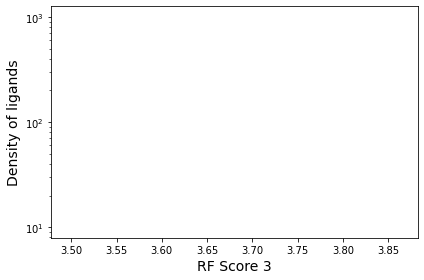

In [ ]:
df_hist['hist_norm'] = df_hist.bincount/df_hist.bincount.sum()/bin_width
ax = df_hist.plot(x="bucket_floor",y="hist_norm",ms=0.5,linewidth=0.75,legend=None)
ax.set_xlabel("RF Score 3",fontsize=14)
ax.set_ylabel("Density of ligands",fontsize=14)
ax.set_yscale('log')
fig = ax.get_figure()
fig.tight_layout()

2D histograms are also possible

In [ ]:
bin_width_x = 0.01
bin_width_y = 0.01
q = """
select floor_x,
       floor_y,
       count(*) as bincount
from (SELECT floor(rf3/{:1.4E})*{:1.4E} AS floor_x, 
             floor(vs_dude_v2/{:1.4E})*{:1.4E} AS floor_y
    FROM mpro_5r84.scores_rank0)
    GROUP BY floor_x, floor_y
    ORDER BY floor_x, floor_y""".format(bin_width_x,bin_width_x,bin_width_y,bin_width_y)
df_hist = client.query(q).to_dataframe()

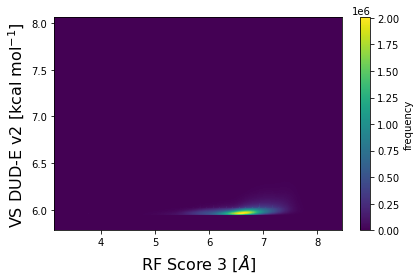

In [ ]:
import numpy as np
x = df_hist.floor_x.values
y = df_hist.floor_y.values
bincount = df_hist.bincount.values
xs = np.unique(x)
ys = np.unique(y)
hist2d_dense = np.zeros((len(xs),len(ys)))
xloc = np.array([np.argwhere(xs==el)[0,0] for el in x])
yloc = np.array([np.argwhere(ys==el)[0,0] for el in y])
hist2d_dense[xloc,yloc] = bincount

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X,Y = np.meshgrid(xs,ys,indexing='ij')
p = ax.pcolor(X,Y,hist2d_dense,cmap='viridis')
ax.set_xlabel("RF Score 3 [$\AA$]",fontsize=16)
ax.set_ylabel("VS DUD-E v2 [kcal mol$^{-1}$]",fontsize=16)
fig.colorbar(p,label='frequency')
fig.tight_layout()

## Sort the compounds by the standard deviation of the RF2 score between runs

Here, we're interested in finding compounds that dock reproducibly in the same pose, assuming that those compounds are strong binders. We achieve this analysis by comparing the spread of scores within the **nruns** independent dockings for each ligand. In the Gigadocking dataset, **nruns=20** (even though some datasets only contain the top 3 poses). Ligands that always end up in the same pose also have very similar scores between runs and therefore a small standard deviation.


In [ ]:
%%bigquery --project $project_id
SELECT * FROM (SELECT name, AVG(rf2) AS rf2_avg, AVG(vs_dude_v2) as vs_avg, AVG(score) AS score_avg, STDDEV_SAMP(rf2) AS rf2_std
    FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
    GROUP BY name
    HAVING rf2_avg > 6
    ORDER BY rf2_std
    LIMIT 10000) AS top
INNER JOIN mpro_5r84.scores_rank0 ON top.name = scores_rank0.name
ORDER BY top.rf2_std LIMIT 100

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM mpro_5r84.confs_all
INNER JOIN (
 SELECT * FROM mpro_5r84.scores_rank0
 INNER JOIN
    (SELECT name AS name_inner, AVG(rf2) AS rf2_avg, AVG(vs_dude_v2) as vs_avg, AVG(score) AS score_avg, STDDEV_SAMP(rf2) AS rf2_std
    FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
    GROUP BY name
    HAVING rf2_avg > 6
    ORDER BY rf2_std
    LIMIT 10000) AS top
  ON top.name_inner = scores_rank0.name
) AS top_outer
ON (confs_all.name = top_outer.name)
#WHERE (confs_all.rank = 0)
ORDER BY top_outer.rf2_std LIMIT 1000

In [ ]:
# download a .zip archive with PDB (use Chrome)
from tqdm.notebook import tqdm
df['pdb'] = df.conf.apply(to_pdb)
pdbs = []
for name,pdb,rank in tqdm(zip(df['name'].values,df['pdb'].values,df['rank'])):
  fn = name+'_rank'+str(rank)+'.pdb'
  with open(fn,'w') as f:
    f.write(pdb)
  pdbs.append(fn)
pdbs = ' '.join(pdbs)
!rm pdb.zip; zip pdb.zip $pdbs
from google.colab import files
files.download('pdb.zip') 


  adding: Z1998288134_3_rank0.pdb (deflated 79%)
  adding: Z1998288134_3_rank3.pdb (deflated 79%)
  adding: Z1998288134_3_rank6.pdb (deflated 79%)
  adding: Z1998288134_3_rank5.pdb (deflated 79%)
  adding: Z1998288134_3_rank14.pdb (deflated 79%)
  adding: Z1998288134_3_rank12.pdb (deflated 79%)
  adding: Z1998288134_3_rank2.pdb (deflated 79%)
  adding: Z1998288134_3_rank18.pdb (deflated 79%)
  adding: Z1998288134_3_rank9.pdb (deflated 79%)
  adding: Z1998288134_3_rank16.pdb (deflated 79%)
  adding: Z1998288134_3_rank17.pdb (deflated 79%)
  adding: Z1998288134_3_rank7.pdb (deflated 79%)
  adding: Z1998288134_3_rank1.pdb (deflated 79%)
  adding: Z1998288134_3_rank8.pdb (deflated 79%)
  adding: Z1998288134_3_rank11.pdb (deflated 79%)
  adding: Z1998288134_3_rank15.pdb (deflated 79%)
  adding: Z1998288134_3_rank13.pdb (deflated 79%)
  adding: Z1998288134_3_rank4.pdb (deflated 79%)
  adding: Z1998288134_3_rank19.pdb (deflated 79%)
  adding: Z1998288134_3_rank10.pdb (deflated 79%)
  adding:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Histogram of standard deviations

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 0.001
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(rf2_std/{})*{} AS bucket_floor FROM 
        (
          SELECT STDDEV_SAMP(rf2) AS rf2_std
          FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
          GROUP BY name
          ORDER BY rf2_std
        ) 
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(bin_width,bin_width)
df_hist = client.query(q).to_dataframe()

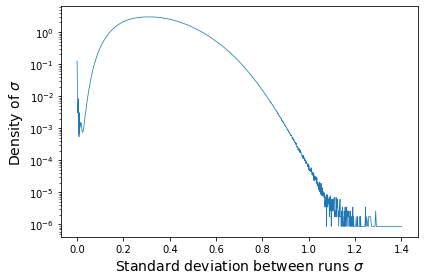

In [ ]:
df_hist['hist_norm'] = df_hist.bincount/df_hist.bincount.sum()/bin_width
ax = df_hist.plot(x="bucket_floor",y="hist_norm",ms=0.5,linewidth=0.75,legend=None)
ax.set_xlabel("Standard deviation between runs $\sigma$",fontsize=14)
ax.set_ylabel("Density of $\sigma$",fontsize=14)
ax.set_yscale('log')
fig = ax.get_figure()
fig.tight_layout()

Here's a version in which we filter out bad (overlapping) compounds by imposing a cut-off on the average score

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)
bin_width = 0.001
q = """
SELECT bucket_floor, COUNT(*) as bincount
FROM (
        SELECT floor(rf2_std/{})*{} AS bucket_floor FROM 
        (
          SELECT STDDEV_SAMP(rf2) AS rf2_std, AVG(rf2) as rf2_avg
          FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
          GROUP BY name
          HAVING rf2_avg > 6
          ORDER BY rf2_std
        ) 
      )
GROUP BY bucket_floor
ORDER BY bucket_floor""".format(bin_width,bin_width)
df_hist = client.query(q).to_dataframe()

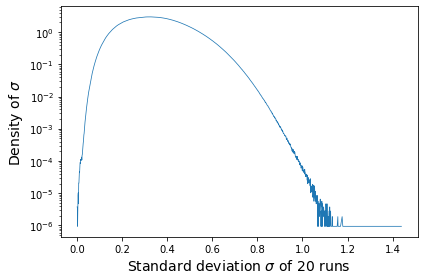

In [ ]:
df_hist['hist_norm'] = df_hist.bincount/df_hist.bincount.sum()/bin_width
ax = df_hist.plot(x="bucket_floor",y="hist_norm",ms=0.5,linewidth=0.75,legend=None)
ax.set_xlabel("Standard deviation $\sigma$ of 20 runs",fontsize=14)
ax.set_ylabel("Density of $\sigma$",fontsize=14)
ax.set_yscale('log')
fig = ax.get_figure()
fig.tight_layout()

Another way to look at the data is to plot standard deviation vs. average

In [ ]:
bin_width_x = 0.001
bin_width_y = 0.01
q = """
select floor_x,
       floor_y,
       count(*) as bincount
from (
    SELECT floor(sigma/{:1.4E})*{:1.4E} AS floor_x, 
           floor(mu/{:1.4E})*{:1.4E} AS floor_y
    FROM 
    (SELECT A.rf2_std AS sigma, A.rf2_avg AS mu FROM
      (
          SELECT name, STDDEV_SAMP(rf2) AS rf2_std, AVG(rf2) as rf2_avg
          FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
          GROUP BY name
          HAVING rf2_avg > 6
      ) AS A INNER JOIN mpro_5r84.scores_rank0 AS B ON A.name = B.name
    )
)
GROUP BY floor_x, floor_y
ORDER BY floor_x, floor_y""".format(bin_width_x,bin_width_x,bin_width_y,bin_width_y)
df_hist2d = client.query(q).to_dataframe()

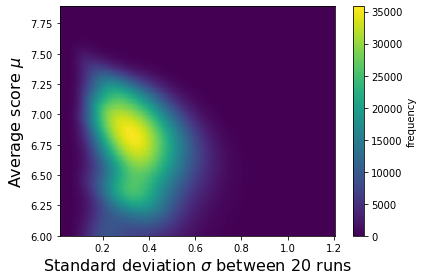

In [ ]:
import numpy as np
x = df_hist2d.floor_x.values
y = df_hist2d.floor_y.values
bincount = df_hist2d.bincount.values
xs = np.unique(x)
ys = np.unique(y)
hist2d_dense = np.zeros((len(xs),len(ys)))
xloc = np.array([np.argwhere(xs==el)[0,0] for el in x])
yloc = np.array([np.argwhere(ys==el)[0,0] for el in y])
hist2d_dense[xloc,yloc] = bincount

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X,Y = np.meshgrid(xs,ys,indexing='ij')
p = ax.pcolor(X,Y,hist2d_dense,cmap='viridis')
ax.set_xlabel("Standard deviation $\sigma$ between 20 runs",fontsize=16)
ax.set_ylabel("Average score $\mu$",fontsize=16)
fig.colorbar(p,label='frequency')
fig.tight_layout()

Now, bring in the VS score for the average

In [ ]:
bin_width_x = 0.001
bin_width_y = 0.01
q = """
select floor_x,
       floor_y,
       count(*) as bincount
from (
    SELECT floor(sigma/{:1.4E})*{:1.4E} AS floor_x, 
           floor(mu/{:1.4E})*{:1.4E} AS floor_y
    FROM 
    (SELECT A.vs_std AS sigma, a.vs_dude_v2_avg AS mu FROM
      (
          SELECT name, STDDEV_SAMP(vs_dude_v2) AS vs_std,
                       AVG(rf2) AS rf2_avg,
                       AVG(vs_dude_v2) as vs_dude_v2_avg
          FROM `cmb-covid19-discovery-collab.mpro_5r84.scores`
          GROUP BY name
          HAVING rf2_avg > 6
      ) AS A INNER JOIN mpro_5r84.scores_rank0 AS B ON A.name = B.name
    )
)
GROUP BY floor_x, floor_y
ORDER BY floor_x, floor_y""".format(bin_width_x,bin_width_x,bin_width_y,bin_width_y)
df_hist2d_vs = client.query(q).to_dataframe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


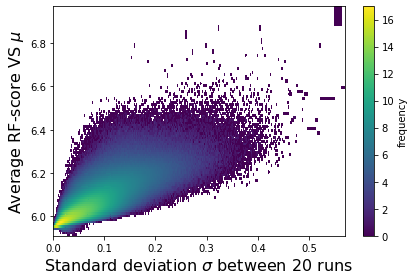

In [ ]:
import numpy as np
x = df_hist2d_vs.floor_x.values
y = df_hist2d_vs.floor_y.values
bincount = df_hist2d_vs.bincount.values
xs = np.unique(x)
ys = np.unique(y)
hist2d_dense = np.zeros((len(xs),len(ys)))
xloc = np.array([np.argwhere(xs==el)[0,0] for el in x])
yloc = np.array([np.argwhere(ys==el)[0,0] for el in y])
hist2d_dense[xloc,yloc] = bincount

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X,Y = np.meshgrid(xs,ys,indexing='ij')
p = ax.pcolor(X,Y,np.log(hist2d_dense),cmap='viridis')
ax.set_xlabel("Standard deviation $\sigma$ between 20 runs",fontsize=16)
ax.set_ylabel("Average RF-score VS $\mu$",fontsize=16)
fig.colorbar(p,label='frequency')
fig.tight_layout()

Try the same plot with autodock scores

In [ ]:
bin_width_x = 0.01
bin_width_y = 0.01
q = """
select floor_x,
       floor_y,
       count(*) as bincount
from (
    SELECT floor(sigma/{:1.4E})*{:1.4E} AS floor_x, 
           floor(mu/{:1.4E})*{:1.4E} AS floor_y
    FROM 
    (SELECT A.score_std AS sigma, a.score_avg AS mu FROM
      (
          SELECT name, STDDEV_SAMP(score) AS score_std,
                       AVG(score) AS score_avg,
          FROM `cmb-covid19-discovery-collab.mpro_5r84.confs_all`
          GROUP BY name
          HAVING score_avg < 0
      ) AS A INNER JOIN mpro_5r84.scores_rank0 AS B ON A.name = B.name
    )
)
GROUP BY floor_x, floor_y
ORDER BY floor_x, floor_y""".format(bin_width_x,bin_width_x,bin_width_y,bin_width_y)
df_hist2d_ad = client.query(q).to_dataframe()

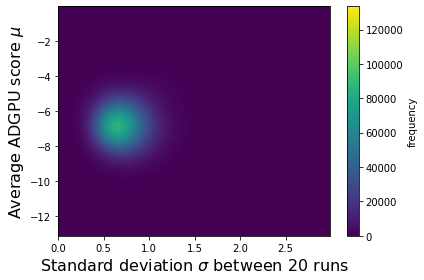

In [ ]:
import numpy as np
x = df_hist2d_ad.floor_x.values
y = df_hist2d_ad.floor_y.values
bincount = df_hist2d_ad.bincount.values
xs = np.unique(x)
ys = np.unique(y)

hist2d_dense = np.zeros((len(xs),len(ys)))
xloc = np.array([np.argwhere(xs==el)[0,0] for el in x])
yloc = np.array([np.argwhere(ys==el)[0,0] for el in y])
hist2d_dense[xloc,yloc] = bincount

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

X,Y = np.meshgrid(xs,ys,indexing='ij')
p = ax.pcolor(X,Y,hist2d_dense,cmap='viridis')
ax.set_xlabel("Standard deviation $\sigma$ between 20 runs",fontsize=16)
ax.set_ylabel("Average ADGPU score $\mu$",fontsize=16)
fig.colorbar(p,label='frequency')
fig.tight_layout()

In [ ]:
!bq show --project_id $project_id mpro_5r84.scores_rank0

Table cmb-covid19-discovery-collab:mpro_5r84.scores_rank0

   Last modified                Schema                Total Rows   Total Bytes    Expiration   Time Partitioning   Clustered Fields   Labels  
 ----------------- --------------------------------- ------------ -------------- ------------ ------------------- ------------------ -------- 
  10 Feb 18:56:32   |- name: string                   1147983152   123807929088                                                               
                    |- vs_dude_v1: float                                                                                                      
                    |- vs_dude_v2: float                                                                                                      
                    |- vs_dude_v3: float                                                                                                      
                    |- vs_dock_v1: float                                           

# The Big Join

In [ ]:
cutoff = 7
q = """
SELECT A.name as name, A.name_first AS enamine_id, A.rf2_avg_5r84, B.rf2_avg_6wqf, C.rf2_avg_7jir, D.rf2_avg_rdrp, E.rf2_avg_nsp15, F.rf2_avg_spike, enamine.*
FROM (SELECT name, SPLIT(name,"_")[OFFSET(0)] as name_first, AVG(rf2) as rf2_avg_5r84 FROM mpro_5r84.scores GROUP BY name HAVING rf2_avg_5r84 > {}) AS A
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_6wqf FROM mpro_6wqf.scores GROUP BY name HAVING rf2_avg_6wqf > {}) AS B ON A.name = B.name
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_7jir FROM plpro_7jir.scores_rf2 GROUP BY name HAVING rf2_avg_7jir > {}) AS C ON A.name = C.name
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_rdrp FROM rdrp.scores_rf2 GROUP BY name HAVING rf2_avg_rdrp > {}) AS D ON A.name = D.name
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_nsp15 FROM nsp15_6wlc.scores_rf2 GROUP BY name HAVING rf2_avg_nsp15 > {}) AS E ON A.name = E.name
INNER JOIN (SELECT name, AVG(rf2) as rf2_avg_spike FROM spike_6m0j.scores_rf2 GROUP BY name HAVING rf2_avg_spike > {}) AS F ON A.name = F.name
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
""".format(*([cutoff]*6))

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [ ]:
columns = [c for c in df.columns if c.startswith('rf2')]
df[(df[columns] > 7.4).all(axis=1)]

,name,enamine_id,rf2_avg_5r84,rf2_avg_6wqf,rf2_avg_7jir,rf2_avg_rdrp,rf2_avg_nsp15,rf2_avg_spike,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
344,Z904792750_1_T1,Z904792750,7.470462,7.419778,7.443273,7.434628,7.678366,7.639744,CN1C=C(S(=O)(=O)NC(=O)C2=C(S(=O)(=O)N3CCSCC3)C...,Z904792750,2014142,2032511,NaN,None,2740,436.562,26,0.338,9,1,5,0.385,118.44,0.718,None,None,None,None,None,True,None,None,None,True,None,S,FSENLBVBXXTELO-UHFFFAOYSA-N
5071,Z1438076742_1_T1,Z1438076742,7.584597,7.522652,7.563805,7.842281,7.750629,7.516381,CCS(=O)(=O)NCCNS(=O)(=O)C1=CC=C(C2=CSC(C)=N2)S1,Z1438076742,2113473,201525,NaN,None,40,395.553,23,1.398,7,2,8,0.417,105.23,0.657,None,True,None,None,None,True,None,None,None,None,None,S,BBXYGDVFRHEXNF-UHFFFAOYSA-N
5250,Z746625760_1_T1,Z746625760,7.565671,7.566727,7.504206,7.438331,7.699931,7.485150,CC1=C(SCC(N)=O)SC(NC(=O)CSC2CCS(=O)(=O)C2)=N1,Z746625760,249524,36837,NaN,None,22,395.553,23,0.888,8,2,7,0.583,119.22,0.658,None,None,None,None,None,True,None,None,None,None,None,S,IBJIGGCXJYDKQP-UHFFFAOYSA-N
5256,Z1066168224_1_T1,Z1066168224,7.446873,7.454228,7.493304,7.472150,7.734466,7.453044,CC1=C(SCC#N)SC(NS(=O)(=O)C2=CC=C(S(C)(=O)=O)C=...,Z1066168224,249510,46666,NaN,None,232682,403.532,24,2.272,8,1,6,0.231,116.99,0.735,None,None,None,None,True,True,None,None,None,None,None,S,XYLHXBKOKMSIQR-UHFFFAOYSA-N
7524,Z2073689057_1_T1,Z2073689057,7.519921,7.559044,7.488400,7.660763,7.812794,7.489850,CC1=C(CCS(=O)(=O)NC(=O)CC2=C(C)N=C(SC(F)F)S2)S...,Z2073689057,6118425,8921200,NaN,None,2740,427.545,25,2.762,8,1,8,0.462,89.02,0.652,None,None,None,None,None,True,None,None,None,None,None,S,UNDURPZBWGJDET-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162780,Z192727784_1_T1,Z192727784,7.467482,7.447444,7.489680,7.430170,7.536784,7.460753,O=C(NC1=NC2=CC=C(SC(F)F)C=C2S1)C1=C(S(=O)(=O)N...,Z192727784,2055,40718,NaN,None,11,491.588,30,3.946,8,1,6,0.294,88.60,0.526,None,None,None,None,None,None,None,None,None,None,None,S,MTRIHFJVWLFMLJ-UHFFFAOYSA-N
163152,Z1708223619_1_T1,Z1708223619,7.496944,7.529536,7.576908,7.507009,7.627827,7.455888,CCC1=CC=C(C2=CSC(NS(=O)(=O)C3=CSC([N+](=O)[O-]...,Z1708223619,33004,3109166,NaN,None,232682,401.516,24,4.205,8,1,6,0.154,102.20,0.492,True,True,None,None,None,None,None,None,None,None,None,S,BIGSRNTXGSQJJW-UHFFFAOYSA-N
163384,Z351271448_1_T1,Z351271448,7.406166,7.426742,7.438757,7.651307,7.480210,7.474512,O=S(CC1=CSC(C2=CC=CS2)=N1)C1=CC=C(S(=O)(=O)N2C...,Z351271448,32646,17193,NaN,None,265282,455.608,28,2.595,8,0,6,0.294,89.46,0.568,None,None,None,None,None,True,None,None,None,None,None,S,SQAFCQOKGGYRHN-UHFFFAOYSA-N
163387,Z351271448_2_T2,Z351271448,7.408597,7.428788,7.501588,7.546191,7.481435,7.425396,O=S(CC1=CSC(C2=CC=CS2)=N1)C1=CC=C(S(=O)(=O)N2C...,Z351271448,32646,17193,NaN,None,265282,455.608,28,2.595,8,0,6,0.294,89.46,0.568,None,None,None,None,None,True,None,None,None,None,None,S,SQAFCQOKGGYRHN-UHFFFAOYSA-N


## Top n-tile list per target

- Mpro 5R84

In [ ]:
ntile = 999
num_ntiles = ntile+1
tab = "mpro_5r84.scores"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf2_avg, vs_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf2_avg, {num_ntiles})[OFFSET({ntile})] AS rf2_ntile,
          APPROX_QUANTILES(vs_avg, {num_ntiles})[OFFSET({ntile})] AS vs_ntile
    FROM (SELECT AVG(rf2) as rf2_avg, AVG(vs_dude_v2) as vs_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf2) as rf2_avg, AVG(vs_dude_v2) as vs_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf2_avg >= ntile.rf2_ntile AND
          B.vs_avg >= ntile.vs_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [ ]:
df

,name,enamine_id,rf2_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z1952071581_2_T1,Z1952071581,7.541451,6.225972,CC(CN(C(=O)C1=C2C=NC=CN2N=C1)C1=CC=CC=C1)NC(=O...,Z1952071581,2786167,3610684,NaN,None,11,440.467,33,2.237,8,1,6,0.130,109.79,0.434,None,None,None,None,None,None,None,None,None,None,None,S,ZEYOJOIRIRTRSY-UHFFFAOYSA-N
1,Z1608129600_1_T1,Z1608129600,7.556409,6.171008,CC1=CC=C(N2C=NN=N2)C=C1NC(=O)NC1CCCOC2=CC(F)=C...,Z1608129600,11929127,2020772,NaN,None,487,382.399,28,3.145,6,2,3,0.263,93.96,0.726,None,None,None,None,None,True,None,None,None,None,None,S,QMDHEGBGWODNOY-UHFFFAOYSA-N
2,Z1602155829_1_T1,Z1602155829,7.588454,6.169903,COC1=CC=CC(CC(C(=O)N(C)C2=CC=C(F)C(Cl)=C2)N2N=...,Z1602155829,11927104,1135281,NaN,None,11,403.845,28,3.229,6,0,6,0.263,73.14,0.631,None,None,None,None,None,True,None,None,None,None,None,S,PFGJVACPTMZFAH-UHFFFAOYSA-N
3,Z2090986382_1_T1,Z2090986382,7.531055,6.169093,CC1=NN=NN1C(=CC1=CC=C(F)C=C1)C(=O)NCC1=C2C=CC=...,Z2090986382,11929637,45402,NaN,None,22,377.383,28,2.083,7,1,5,0.105,90.00,0.538,None,True,None,None,True,True,None,None,None,None,None,S,LITTYFJQLRRXQD-UHFFFAOYSA-N
4,Z1833768807_1_T6,Z1833768807,7.564418,6.167781,COC(=O)C1=N[NH]C(C2=CC=CC=C2CNC(=O)C2=CC3=C(C=...,Z1833768807,11923293,12500140,NaN,None,22,394.366,29,2.204,6,3,5,0.105,125.65,0.446,None,None,None,None,None,True,None,None,None,None,None,S,SGXXOOHQYSAHMN-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17025,Z1023722616_1_T1,Z1023722616,7.631934,6.289768,O=C(NCCC(=O)N1CCN(C2=NC=CC=N2)CC1)C1=C(C(F)(F)...,Z1023722616,2101793,2078504,NaN,None,22,492.437,35,1.684,8,1,6,0.333,109.14,0.522,None,None,None,None,None,None,None,None,None,None,None,S,RYEVOHWVAUKOCI-UHFFFAOYSA-N
17026,Z1161214541_1_T1,Z1161214541,7.529291,6.209270,CC1=C(C(=O)NCCC(=O)N2CCN(C3=NC=CC=N3)CC2)N=NN1...,Z1161214541,2101793,2783989,NaN,None,22,471.525,35,1.383,9,1,6,0.292,122.03,0.448,None,None,None,None,None,None,None,None,None,None,None,S,JDOODAOJHIILBQ-UHFFFAOYSA-N
17027,Z1088492438_2_T1,Z1088492438,7.540047,6.239353,CC1=NN=NN1C1=CC(NC(=O)N2CCCC(CN3CCN(C4=CC=CC=N...,Z1088492438,2099524,2049488,NaN,None,2430,479.564,35,2.571,8,1,5,0.458,95.31,0.601,None,None,None,None,None,None,None,None,None,True,None,S,FZSLTLHFSJJBLC-UHFFFAOYSA-N
17028,Z1027969308_1_T1,Z1027969308,7.532519,6.214798,COC1=CC=C(NC(=O)N2CCN(C(C)C(=O)NC3=CC=CC(F)=C3...,Z1027969308,2099525,526009,NaN,None,2430,482.520,35,2.295,8,2,6,0.348,117.51,0.554,None,None,None,None,True,None,None,None,None,None,None,S,GNWGJXVJKDJYTJ-UHFFFAOYSA-N


In [ ]:
df.to_gbq('mpro_5r84.top_0001',project_id=project_id,if_exists='replace')

1it [00:07,  7.41s/it]


In [ ]:
ntile = 999
num_ntiles = ntile+1
tab = "mpro_6wqf.scores"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf2_avg, vs_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf2_avg, {num_ntiles})[OFFSET({ntile})] AS rf2_ntile,
          APPROX_QUANTILES(vs_avg, {num_ntiles})[OFFSET({ntile})] AS vs_ntile
    FROM (SELECT AVG(rf2) as rf2_avg, AVG(vs_dude_v2) as vs_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf2) as rf2_avg, AVG(vs_dude_v2) as vs_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf2_avg >= ntile.rf2_ntile AND
          B.vs_avg >= ntile.vs_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [ ]:
df

,name,enamine_id,rf2_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z1337023943_4_T4,Z1337023943,7.384624,6.186021,O=C(NCC1CCCC1NC(=O)C1=CC(F)=CC2=C1N=C[NH]2)C1=...,Z1337023943,2106543,2013961,NaN,None,22,438.438,32,3.046,4,4,5,0.273,115.56,0.383,None,None,None,None,None,None,None,None,None,None,None,S,BOSCEGQNVNANIP-UHFFFAOYSA-N
1,Z1495052324_15_T1,Z1495052324,7.393722,6.131027,CC1=NN=C2CCC(C(=O)NCC3CCCC3NC(=O)C3CCC4=NN=C(C...,Z1495052324,2106543,2014580,NaN,None,22,440.552,32,0.713,8,2,5,0.727,119.62,0.707,None,None,None,None,None,None,None,None,None,True,None,S,KITLUKQUOCUMSJ-UHFFFAOYSA-N
2,Z1669161724_4_T1,Z1669161724,7.441037,6.168622,CN1N=NC2=CC=C(C(=O)NCC3CCCC3NC(=O)C3=CC=C4N=NN...,Z1669161724,2106543,3768876,NaN,None,22,432.488,32,1.578,8,2,5,0.364,119.62,0.494,None,None,None,None,None,None,None,None,None,True,None,S,LHANPXKNEPXVHU-UHFFFAOYSA-N
3,Z1493323396_2_T1,Z1493323396,7.451289,6.132939,COC1=CC=CC=C1N1CCC(NC(=O)CC2=C(C)N(C3=CN=CC4=N...,Z1493323396,3847305,10990201,NaN,None,22,447.503,33,1.268,10,1,6,0.364,115.36,0.470,None,None,None,None,None,None,None,None,None,True,None,S,KFFJVYBNUAUADM-UHFFFAOYSA-N
4,Z2228930519_2,Z2228930519,7.382402,6.130756,CC1=NN=NN1C(=CC1=CC=C(F)C=C1)C(=O)NC[C@@H]1C[C...,Z2228930519,4866172,45402,NaN,None,22,448.474,32,2.582,7,1,5,0.476,102.24,0.706,None,True,None,None,True,True,None,None,None,True,None,S,IITYDPHVKVKMHV-IRXDYDNUSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20952,Z384095618_1_T1,Z384095618,7.465698,6.221978,CCC(NC(=O)C1CCN(C2=NN3C(C(F)(F)F)=NN=C3C=C2)CC...,Z384095618,143018,41980,NaN,None,527,498.456,35,4.228,7,1,7,0.455,84.65,0.491,None,None,None,None,None,None,None,None,None,None,None,S,UWFPYLTVXCFHFL-UHFFFAOYSA-N
20953,Z453946510_2_T1,Z453946510,7.409274,6.166749,CC1=NN=NN1C(=CC1=CC=C(F)C=C1)C(=O)N1CCN(C(=O)C...,Z453946510,139266,45402,NaN,None,22,488.445,35,3.122,6,0,4,0.261,84.22,0.416,None,True,None,None,True,None,None,None,None,None,None,S,JSFMSNSDSQMTKW-UHFFFAOYSA-N
20954,Z512229134_2_T2,Z512229134,7.440215,6.179481,CC(NC(=O)NNC1=CC=C(N2C=CC=N2)N=N1)C1=CC=CC(NC(...,Z512229134,142426,1000239,NaN,None,2708,474.500,35,3.370,7,4,8,0.125,125.86,0.290,None,True,None,None,True,None,None,None,None,None,None,S,NZBQNKHOEHWBIS-UHFFFAOYSA-N
20955,Z512229134_1_T2,Z512229134,7.381580,6.144878,CC(NC(=O)NNC1=CC=C(N2C=CC=N2)N=N1)C1=CC=CC(NC(...,Z512229134,142426,1000239,NaN,None,2708,474.500,35,3.370,7,4,8,0.125,125.86,0.290,None,True,None,None,True,None,None,None,None,None,None,S,NZBQNKHOEHWBIS-UHFFFAOYSA-N


In [ ]:
df.to_gbq('mpro_6wqf.top_0001',project_id=project_id,if_exists='replace')

1it [00:08,  8.03s/it]


In [ ]:
ntile = 999
num_ntiles = ntile+1
tab = "plpro_7jir.scores"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf3_avg, vs_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf3_avg, {num_ntiles})[OFFSET({ntile})] AS rf3_ntile,
          APPROX_QUANTILES(vs_avg, {num_ntiles})[OFFSET({ntile})] AS vs_ntile
    FROM (SELECT AVG(rf3) as rf3_avg, AVG(vs_dude_v2) as vs_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf3) as rf3_avg, AVG(vs_dude_v2) as vs_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf3_avg >= ntile.rf3_ntile AND
          B.vs_avg >= ntile.vs_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [ ]:
df

,name,enamine_id,rf3_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z994049238_1_T3,Z994049238,7.784366,6.343651,O=C(NC1=CC=C(C2=NOC(=O)[NH]2)C=C1)C1=CC=C2C(=O...,Z994049238,8680859,13367,NaN,None,527,440.415,33,3.078,6,2,5,0.042,125.37,0.460,None,True,None,None,True,None,None,None,None,None,None,S,MEALOZYKDMREPC-UHFFFAOYSA-N
1,Z1488517506_2_T1,Z1488517506,7.718129,6.301078,CC(C1=CC=NC=C1)N1CCC(NC(=O)C2=CC(C3=CC=C4OCCC4...,Z1488517506,8932545,9180823,NaN,None,527,418.497,31,3.627,6,1,5,0.375,80.49,0.682,None,None,None,None,None,None,None,None,None,True,None,S,HJYAAYGGCOXUHA-UHFFFAOYSA-N
2,Z1488522093_1_T1,Z1488522093,7.764102,6.345015,CC(C1=CC=NC=C1)N1CCC(NC(=O)C2=NN(C3=CC=CC(C(F)...,Z1488522093,8932545,3566371,NaN,None,22,443.473,32,4.242,5,1,5,0.348,63.05,0.641,None,None,None,None,None,None,None,None,None,None,None,S,LLRMLIUUUUXWIH-UHFFFAOYSA-N
3,Z1532995824_1_T1,Z1532995824,7.795690,6.303982,CC(=NNC1=NC2=CC=CC=C2C(=O)[NH]1)C1=CC=C(OC2=CC...,Z1532995824,2996158,3990117,NaN,None,4,414.421,31,4.250,6,3,6,0.043,116.67,0.321,None,True,None,None,True,None,None,None,None,None,None,S,CEHVFLSSQGSLAZ-UHFFFAOYSA-N
4,Z1532995824_2_T1,Z1532995824,7.750852,6.309643,CC(=NNC1=NC2=CC=CC=C2C(=O)[NH]1)C1=CC=C(OC2=CC...,Z1532995824,2996158,3990117,NaN,None,4,414.421,31,4.250,6,3,6,0.043,116.67,0.321,None,True,None,None,True,None,None,None,None,None,None,S,CEHVFLSSQGSLAZ-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5445,Z1553194729_2_T2,Z1553194729,7.699319,6.300529,O=C(CN1C(=O)NC2(CCC3=CC=CC=C32)C1=O)OCC1=CC=C(...,Z1553194729,13055,11906663,NaN,None,1458,444.447,33,2.706,7,1,6,0.208,110.72,0.460,None,True,None,None,True,None,None,None,None,None,None,S,UEBRQXZQSKOYTE-UHFFFAOYSA-N
5446,Z145422656_1_T1,Z145422656,7.674230,6.309612,CCOC1=CC=C(C(=O)NNC(=O)C2=CC(C3=CC=CC=C3)=NC3=...,Z145422656,13595,31222,NaN,None,22,473.533,35,4.161,7,2,7,0.231,107.37,0.390,None,True,None,None,True,None,None,None,None,None,None,S,HZKIEAKGABRLGC-UHFFFAOYSA-N
5447,Z136142886_1_T1,Z136142886,7.704059,6.298323,CCOC1=CC=C(C(=O)NNC(=O)C2=CC=C(N3C(C)=NC4=CC=C...,Z136142886,13595,32051,NaN,None,22,472.501,35,3.176,7,2,6,0.154,111.55,0.417,None,True,None,None,True,None,None,None,None,None,None,S,FUBWELYHVCWORI-UHFFFAOYSA-N
5448,Z18184429_1_T2,Z18184429,7.697721,6.403757,O=C(CN1C(=O)NC2(CCC3=CC=CC=C32)C1=O)OCC(=O)N1C...,Z18184429,13055,221477,NaN,None,1458,480.496,35,1.411,6,1,5,0.360,99.26,0.513,None,True,None,None,True,None,None,None,None,True,None,S,JBCRUGQQYZUXNT-UHFFFAOYSA-N


In [ ]:
df.to_gbq('plpro_7jir.top_001',project_id=project_id,if_exists='replace')

1it [00:03,  3.97s/it]


In [ ]:
ntile = 999
num_ntiles = ntile+1
tab = "rdrp.scores"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf3_avg, vs_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf3_avg, {num_ntiles})[OFFSET({ntile})] AS rf3_ntile,
          APPROX_QUANTILES(vs_avg, {num_ntiles})[OFFSET({ntile})] AS vs_ntile
    FROM (SELECT AVG(rf3) as rf3_avg, AVG(vs_dude_v2) as vs_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf3) as rf3_avg, AVG(vs_dude_v2) as vs_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf3_avg >= ntile.rf3_ntile AND
          B.vs_avg >= ntile.vs_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [ ]:
df

,name,enamine_id,rf3_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z1953144822_2_T1,Z1953144822,7.523957,6.214590,CC1=NN(C2=CC=CC=C2)C2=NC=C(C(=O)NCC3CC(C(N)=O)...,Z1953144822,15329480,73594,NaN,None,22,378.392,28,1.089,7,2,5,0.211,124.49,0.688,None,None,None,None,True,True,None,None,None,None,None,S,ANRXRLFJJIJUQM-UHFFFAOYSA-N
1,Z1098709147_2_T2,Z1098709147,7.600018,6.215306,O=C(CC1SC(N2CCCCC2)=NC1=O)NC1=CC(C(=O)NC2=N[NH...,Z1098709147,2223479,16034,NaN,None,22,494.552,35,3.767,6,3,5,0.292,119.55,0.497,None,None,None,None,True,None,None,None,None,None,None,S,KJOBWFGVNJTIFP-UHFFFAOYSA-N
2,Z1137451163_1_T3,Z1137451163,7.518023,6.339822,O=C(CCCCCC(=O)NC1=N[NH]C2=CC=C(F)C=C12)NC1=N[N...,Z1137451163,2223479,455,NaN,None,22,426.427,31,4.245,4,4,8,0.238,115.56,0.315,None,True,None,None,None,None,None,None,None,None,None,S,ZQWYUKZKJSZXQO-UHFFFAOYSA-N
3,Z2007555877_2_T2,Z2007555877,7.706364,6.230524,CN1C(C2=N[NH]C(=O)C3=CC=CC=C23)=NN=C1N1CCC(NC(...,Z2007555877,12,2057434,8928.0,None,270942,448.462,33,2.258,7,3,4,0.227,120.83,0.440,None,None,None,None,None,None,None,None,None,None,None,S,UZUCWTBMLCAANL-UHFFFAOYSA-N
4,Z2007899951_1,Z2007899951,7.538650,6.240991,CC1=CC=C(NC(=O)NCC2CCCN(C3=NN=C(C(=O)NC4=CC=CC...,Z2007899951,12,2061506,3123162.0,None,270942,448.531,33,2.809,7,3,6,0.348,117.07,0.534,None,None,None,None,None,True,None,None,None,None,None,S,ZUJWUCBCRWJQCV-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6537,Z758992822_1_T1,Z758992822,7.531969,6.271618,CC1=CC(C)=C(C2=N[NH]C(NC(=O)C3CCN(C4=NN5C(C(F)...,Z758992822,8072,41980,NaN,None,527,498.513,36,4.314,7,2,4,0.375,104.10,0.435,None,None,None,None,None,None,None,None,None,None,None,S,AIYAKFQZGQWLNF-UHFFFAOYSA-N
6538,Z333045316_1_T1,Z333045316,7.563557,6.296688,O=C(C1=CC(NS(=O)(=O)C2=CC=C3N=NN(O)C3=C2)=CC=C...,Z333045316,8437,13949,NaN,None,527,475.490,34,2.479,9,2,4,0.091,135.24,0.381,None,True,None,None,True,None,None,None,None,None,None,S,IISQVKXQIBZKBC-UHFFFAOYSA-N
6539,Z295741368_1_T1,Z295741368,7.587759,6.233539,O=C(CC1SC(N2CCCC2)=NC1=O)NC1=CC=C(C(=O)N2CCN3C...,Z295741368,8437,16464,NaN,None,527,488.573,35,3.119,7,1,4,0.320,99.90,0.606,None,None,None,None,True,None,None,None,None,None,None,S,RXOKUZLHNRMHQN-UHFFFAOYSA-N
6540,Z365247662_1_T1,Z365247662,7.552356,6.236124,CC1=CC(C(=O)N2CCN(S(=O)(=O)C3=CC=C4C=CC=CC4=C3...,Z365247662,8116,126743,NaN,None,22,462.535,33,2.271,7,0,4,0.217,101.29,0.461,None,None,None,None,None,None,None,None,None,None,None,S,ABQCXJBQYRMMLN-UHFFFAOYSA-N


In [ ]:
df.to_gbq('rdrp.top_001',project_id=project_id,if_exists='replace')

1it [00:05,  5.01s/it]


In [ ]:
ntile = 999
num_ntiles = ntile+1
tab = "nsp15_6wlc.scores_rf2"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf2_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf2_avg, {num_ntiles})[OFFSET({ntile})] AS rf2_ntile
    FROM (SELECT AVG(rf2) as rf2_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf2) as rf2_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf2_avg >= ntile.rf2_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [ ]:
df

,name,enamine_id,rf2_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z1579504842_1_T2,Z1579504842,7.512038,CC1=CC(C2=NC(C(=O)OCC(=O)NC3=CC(N4N=NN=C4C)=CC...,Z1579504842,8441434,10011131,NaN,None,1458,449.446,33,2.912,8,2,6,0.182,127.68,0.433,None,None,None,None,True,True,None,None,None,None,None,S,WHOYOEVQABUZRP-UHFFFAOYSA-N
1,Z1579504842_1_T1,Z1579504842,7.446473,CC1=CC(C2=NC(C(=O)OCC(=O)NC3=CC(N4N=NN=C4C)=CC...,Z1579504842,8441434,10011131,NaN,None,1458,449.446,33,2.912,8,2,6,0.182,127.68,0.433,None,None,None,None,True,True,None,None,None,None,None,S,WHOYOEVQABUZRP-UHFFFAOYSA-N
2,Z1453991683_1_T1,Z1453991683,7.471403,CC1=CC=C(N2N=CC=C2NC(=O)C2=CC3=C(S2)N(C2=CC=C(...,Z1453991683,8446174,2119,NaN,None,11,449.927,31,4.585,8,1,4,0.095,90.52,0.433,None,None,None,None,None,None,None,None,None,None,None,S,RMROSSBBEKWFGT-UHFFFAOYSA-N
3,Z1453991185_1_T1,Z1453991185,7.431835,CC1=CC=C(N2N=CC=C2NC(=O)C2=CC3=C(S2)N(C2=CC=CC...,Z1453991185,8446174,2184,NaN,None,11,449.927,31,4.585,8,1,4,0.095,90.52,0.433,None,None,None,None,None,None,None,None,None,None,None,S,UGCFKYRLZVPWCA-UHFFFAOYSA-N
4,Z1453991681_1_T1,Z1453991681,7.439115,CC1=CC=C(N2N=CC=C2NC(=O)C2=CC=C(N3CCC(C)CC3)C(...,Z1453991681,8446174,4028,NaN,None,11,421.461,31,3.368,8,1,5,0.333,119.08,0.495,None,True,None,None,True,True,None,None,None,None,None,S,CYEQGEBMDUVOMQ-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405542,Z807244792_1_T1,Z807244792,7.430537,N#CCOC1=CC(NC(=O)NCC2=CC=C(N3CCN(C4=NC=CC=N4)C...,Z807244792,159908,2016271,NaN,None,2430,461.501,34,3.166,7,2,7,0.250,106.41,0.557,None,None,None,None,True,None,None,None,None,None,None,S,NGTNGQZKJOIABO-UHFFFAOYSA-N
405543,Z604330642_1_T1,Z604330642,7.439504,COC1=CC=C(NC(=O)N2CCN(C3=NC=CC=N3)CC2)C=C1NC(=...,Z604330642,162032,2027,NaN,None,2430,484.919,34,3.884,6,2,5,0.217,99.69,0.570,None,None,None,None,True,None,None,None,None,None,None,S,VVBXRCAFZHVVNA-UHFFFAOYSA-N
405544,Z604336072_1_T1,Z604336072,7.447403,COC1=CC=C(NC(=O)NCC2=NN=C3CCCCCN32)C=C1NC(=O)C...,Z604336072,162032,32027,NaN,None,2430,486.935,34,4.380,6,3,6,0.304,110.17,0.479,None,None,None,None,True,None,None,None,None,None,None,S,HDHVHXDLVIXGJL-UHFFFAOYSA-N
405545,Z604339488_2_T1,Z604339488,7.491415,COC1=CC=C(NC(=O)NC(C)C2=NN=C3C=CC=CN23)C=C1NC(...,Z604339488,162032,221762,NaN,None,2430,482.903,34,4.665,6,3,6,0.130,109.65,0.370,None,None,None,None,True,None,None,None,None,None,None,S,DRTVKIZRMAFTDP-UHFFFAOYSA-N


In [ ]:
df.to_gbq('nsp15_6wlc.top_001',project_id=project_id,if_exists='replace')

1it [00:49, 49.60s/it]


In [ ]:
ntile = 999
num_ntiles = ntile+1
tab = "spike_6m0j.scores_rf2"
q = f"""

SELECT A.name as name, A.name_first AS enamine_id, rf2_avg, enamine.*
FROM (
  WITH ntile AS (
    SELECT APPROX_QUANTILES(rf2_avg, {num_ntiles})[OFFSET({ntile})] AS rf2_ntile
    FROM (SELECT AVG(rf2) as rf2_avg FROM {tab} GROUP BY name)
  )
  SELECT SPLIT(name,"_")[OFFSET(0)] as name_first, * FROM
    (SELECT name, AVG(rf2) as rf2_avg
      FROM {tab}
      GROUP BY name
    ) AS B
    CROSS JOIN ntile
    WHERE B.rf2_avg >= ntile.rf2_ntile
) AS A
INNER JOIN enamine_2020q1.smiles AS enamine ON A.name_first = enamine.idnumber
"""


from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df = client.query(q).to_dataframe()

In [ ]:
df

,name,enamine_id,rf2_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
0,Z2773204134_1_T1,Z2773204134,7.056219,CC1(C)CN(S(=O)(=O)N=S2(=O)CCCC2)CCN1,Z2773204134,7755271,19205651,NaN,None,270084,295.430,18,0.177,4,1,2,1.000,78.84,0.788,None,None,None,None,None,True,True,None,None,None,None,M,YIHVGHQNEDBCGF-UHFFFAOYSA-N
1,Z1902975195_69_T1,Z1902975195,7.068010,COC(=O)C1=CC=C(N2C=C(C)C=N2)C(NC(=O)NCC2(O)C3C...,Z1902975195,7762247,17435054,NaN,None,2430,448.523,33,2.598,6,3,5,0.560,105.48,0.610,None,None,None,None,True,None,None,None,None,None,None,S,LIFNVUASKAXRDM-UHFFFAOYSA-N
2,Z2443909871_2_T1,Z2443909871,7.163374,CS(=O)(=O)C1=CC=C(S(=O)(=O)NC2CCCNCC2)C=N1,Z2443909871,7752836,9983764,NaN,None,270084,333.435,21,-0.094,6,2,4,0.583,105.23,0.797,None,None,None,None,None,True,True,None,None,None,None,S,QFKHUTPBNWFFST-UHFFFAOYSA-N
3,Z2592426083_1_T1,Z2592426083,7.265567,CC1(C)CN(S(=O)(=O)C2=CC=C(S(N)(=O)=O)C=C2)CCN1,Z2592426083,7755271,38044,NaN,None,270084,333.435,21,-0.293,5,2,3,0.500,109.57,0.790,None,None,None,None,None,True,True,None,None,None,None,S,SWHBSBQISLOHFF-UHFFFAOYSA-N
4,Z2443908322_1_T1,Z2443908322,7.054570,CC(=O)NCCC1=CC=C(S(=O)(=O)NC2CCCNCC2)S1,Z2443908322,7752836,189324,NaN,None,270084,345.490,22,0.847,5,3,6,0.643,87.30,0.713,None,None,None,None,None,True,True,None,None,None,None,S,VSCIQEJHMHIRHE-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701712,Z384907810_1_T1,Z384907810,7.050567,N#CC(C(=O)CC1=CSC(NC(=O)CC2=CC=CS2)=N1)C1=NC2=...,Z384907810,45124,99790,NaN,None,276436,471.514,32,4.550,8,1,8,0.190,100.67,0.406,True,None,None,None,None,None,None,None,None,None,None,S,UIFGZJJZNJNIOM-UHFFFAOYSA-N
701713,Z384914350_2_T2,Z384914350,7.045044,CC1=C(C)C2=C(N=C(CSC(C)C(=O)C(C#N)C3=NC4=CC=CC...,Z384914350,45124,14031,NaN,None,276436,487.557,33,4.844,8,1,7,0.318,104.43,0.400,None,None,None,None,None,None,None,None,None,None,None,S,IXMRXCYFDKWQCB-UHFFFAOYSA-N
701714,Z384912020_1_T1,Z384912020,7.037417,N#CC(C(=O)CN1C=NC2=C(C(C3=CC=CS3)=CS2)C1=O)C1=...,Z384912020,45124,31732,NaN,None,276436,481.509,33,4.808,9,0,6,0.136,93.57,0.347,None,None,None,None,None,None,None,None,None,None,None,S,PHBAZIKVIGWNJB-UHFFFAOYSA-N
701715,Z384914332_2_T1,Z384914332,7.093900,N#CC(C(=O)CSCC1=NC2=C(C3=C(CCCC3)S2)C(=O)[NH]1...,Z384914332,45124,12970,NaN,None,276436,499.568,34,4.718,8,1,7,0.348,104.43,0.395,None,None,None,None,True,None,None,None,None,None,None,S,GTFWEJGBMZXANR-UHFFFAOYSA-N


In [ ]:
df.to_gbq('spike_6m0j.top_001',project_id=project_id,if_exists='replace')

1it [01:25, 85.87s/it]


## Filter down further and extract conformations

- 5R84

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM mpro_5r84.top_0001

In [ ]:
q = 0.95
df_select = df[(df.rf2_avg >= df.rf2_avg.quantile(q)) & (df.vs_avg >= df.vs_avg.quantile(q))] 

In [ ]:
q = """
WITH compounds AS (SELECT {})
SELECT A.conf, B.* FROM mpro_5r84.confs_all AS A
INNER JOIN compounds ON compounds.name = A.name
INNER JOIN mpro_5r84.top_0001 AS B ON B.name = A.name
WHERE A.rank = 0
""".format('UNION ALL SELECT '.join(['"'+name+'" AS name\n' for name in df_select.name]))

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_conf = client.query(q).to_dataframe()

In [ ]:
df_conf.to_parquet('top_5r84_conf.parquet')
from google.colab import files
files.download('top_5r84_conf.parquet')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- 6WQF

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM mpro_6wqf.top_0001

In [ ]:
q = 0.965
df_select = df[(df.rf2_avg >= df.rf2_avg.quantile(q)) & (df.vs_avg >= df.vs_avg.quantile(q))] 

In [ ]:
df_select

,name,enamine_id,rf2_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
186,Z995289194_1_T3,Z995289194,7.528004,6.261316,C(=NNC1=NC(C2=CC=NC=C2)=NO1)C1=CN(CC2=CC=CC=C2...,Z995289194,2120464,37067,NaN,None,4,493.527,37,4.651,10,1,7,0.148,112.48,0.258,None,True,None,None,True,None,None,None,None,None,None,S,PGAMTKXLWRBQNE-UHFFFAOYSA-N
385,Z1157849381_1_T12,Z1157849381,7.535135,6.258510,CCCCOC1=CC=C(C2=NN(C3=CC=CC=C3)C=C2C=NNC2=NC3=...,Z1157849381,2784237,8775,NaN,None,4,486.511,36,4.263,8,3,9,0.160,125.87,0.162,None,True,None,None,True,None,None,None,None,None,None,S,VUBZCPZOGQDKET-UHFFFAOYSA-N
543,Z279732450_1_T3,Z279732450,7.542895,6.262161,O=C1C(C=NNC2=C3C=CC=CC3=NC(C(F)(F)F)=N2)=C(N2C...,Z279732450,32085,46990,NaN,None,4,469.427,34,2.939,9,1,4,0.227,97.01,0.363,None,True,None,None,True,None,None,None,None,None,None,S,GBVZYIXODFIWEG-UHFFFAOYSA-N
546,Z279732450_1_T1,Z279732450,7.541948,6.252966,O=C1C(C=NNC2=C3C=CC=CC3=NC(C(F)(F)F)=N2)=C(N2C...,Z279732450,32085,46990,NaN,None,4,469.427,34,2.939,9,1,4,0.227,97.01,0.363,None,True,None,None,True,None,None,None,None,None,None,S,GBVZYIXODFIWEG-UHFFFAOYSA-N
547,Z279732450_2_T3,Z279732450,7.577179,6.257444,O=C1C(C=NNC2=C3C=CC=CC3=NC(C(F)(F)F)=N2)=C(N2C...,Z279732450,32085,46990,NaN,None,4,469.427,34,2.939,9,1,4,0.227,97.01,0.363,None,True,None,None,True,None,None,None,None,None,None,S,GBVZYIXODFIWEG-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20397,Z951463152_1_T1,Z951463152,7.556859,6.269364,CC(C)(C)OC(=O)NCCNC(=O)C1CCCN(CC2=NN=NN2C2=CC=...,Z951463152,2049801,2014273,NaN,None,2230,497.522,35,2.534,8,2,7,0.591,114.27,0.565,None,True,None,None,None,None,None,None,None,True,None,S,UVCINOUYPAXDSL-UHFFFAOYSA-N
20504,Z638443162_2_T1,Z638443162,7.567474,6.288704,N#CC(C(=O)C1CC(=O)N(CC2=CC=CC(C(F)(F)F)=C2)C1)...,Z638443162,40438,176005,NaN,None,276436,495.465,36,3.441,8,2,7,0.250,137.89,0.508,None,None,None,None,None,None,None,None,None,None,None,S,MRKDWNRSSCFYSZ-UHFFFAOYSA-N
20629,Z643783390_3_T2,Z643783390,7.537159,6.261956,COC1=CC=CC(C=C(C(=O)C(C#N)C2=NC3=CC=CC=C3N2C(F...,Z643783390,45124,45312,NaN,None,276436,449.421,33,3.610,9,0,7,0.182,111.51,0.396,None,True,None,None,True,True,None,None,None,None,None,S,WJQACTAITARNAG-UHFFFAOYSA-N
20741,Z978685856_2_T2,Z978685856,7.528692,6.263046,N#CC(C(=O)C1=CC=CC(N2N=CC=C2C(F)(F)F)=C1)C1=NC...,Z978685856,40438,2078855,NaN,None,276436,464.411,34,3.892,9,2,6,0.091,135.40,0.410,None,None,None,None,None,None,None,None,None,None,None,S,HVJZBYUZHRCBIM-UHFFFAOYSA-N


In [ ]:
q = """
WITH compounds AS (SELECT {})
SELECT A.conf, B.* FROM mpro_6wqf.confs_all AS A
INNER JOIN compounds ON compounds.name = A.name
INNER JOIN mpro_6wqf.top_0001 AS B ON B.name = A.name
WHERE A.rank = 0
""".format('UNION ALL SELECT '.join(['"'+name+'" AS name\n' for name in df_select.name]))

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_conf = client.query(q).to_dataframe()

In [ ]:
fn = 'top_6wqf_conf.parquet'
df_conf.to_parquet(fn)
from google.colab import files
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- PLpro

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM plpro.top_001

In [ ]:
q = 0.85
df_select = df[(df.rf3_avg >= df.rf3_avg.quantile(q)) & (df.vs_avg >= df.vs_avg.quantile(q))] 
df_select

,name,enamine_id,rf3_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
66,Z803913034_1_T1,Z803913034,7.892082,6.353206,O=C(CCC1=CC(F)=CC=C1F)NNC(=O)C1=CC=C(CN2C(=O)C...,Z803913034,3787,2016946,NaN,None,22,485.490,36,4.672,3,2,6,0.107,78.51,0.390,None,True,None,None,True,None,None,None,None,None,None,S,PLOUDUFYMMYFBO-UHFFFAOYSA-N
68,Z27150347_1_T1,Z27150347,7.871510,6.408050,CC1=CC=CC=C1C(=O)NNC(=O)C1=CC=C(CN2C(=O)C3=C4C...,Z27150347,3787,1568,NaN,None,22,435.483,33,4.383,3,2,4,0.074,78.51,0.467,None,True,None,None,True,None,None,None,None,None,None,S,YVKOALSMXKHSGH-UHFFFAOYSA-N
212,Z51778027_2_T1,Z51778027,7.848549,6.393164,O=C(NNC(=O)C1CC(=O)N(C2CCCC2)C1)C1=CC=C(CN2C(=...,Z51778027,3787,31307,NaN,None,11,496.567,37,3.552,4,2,5,0.310,98.82,0.528,None,True,None,None,True,None,None,None,None,None,None,S,LJSNKMLCXSJPRS-UHFFFAOYSA-N
271,Z1514421151_11,Z1514421151,7.906392,6.376934,NC(=O)C1=CC=C(C=CC(=O)N2CCCC2C(=O)NC2C3CCOC3C2...,Z1514421151,11281494,2018592,NaN,None,11,437.540,32,2.254,4,2,5,0.560,101.73,0.690,None,True,None,None,True,None,None,None,None,True,True,S,MJCGTLLWFJYXCH-UHFFFAOYSA-N
326,Z1511822000_1_T1,Z1511822000,7.944760,6.363499,CC1=CC=C(C(=O)N2CCCC3=C([N+](=O)[O-])C=CC=C32)...,Z1511822000,2808279,94655,NaN,None,11,433.439,32,4.888,4,1,4,0.167,92.55,0.468,None,True,None,None,True,None,None,None,None,None,None,S,WJRVBPVSSGCUIC-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4954,Z1685321062_2_T2,Z1685321062,7.930355,6.370615,CC1=NN=C(C2=CC=CC(C3=NOC(C4=CC=C5C(=O)OC(C6=CC...,Z1685321062,3572136,31759,NaN,None,270196,449.470,34,4.951,7,1,4,0.115,106.79,0.387,None,None,None,None,None,None,None,None,None,None,None,S,JAGBTRUTWXTGJP-UHFFFAOYSA-N
5013,Z29008681_1_T1,Z29008681,7.836589,6.358938,CN1C(=O)C2=CC=C(C(=O)NNC(=O)C3=NN(CC4=CC=CC=C4...,Z29008681,6945,16250,NaN,None,22,481.468,36,1.745,7,2,4,0.077,130.47,0.337,None,True,None,None,True,None,None,None,None,None,None,S,IXQKBPNYIUTMJO-UHFFFAOYSA-N
5061,Z56844141_2_T1,Z56844141,7.942702,6.374812,O=C1COC2=CC=C(C(=O)COC(=O)C=CC3=CN(C4=CC=CC=C4...,Z56844141,23820130,4097,NaN,None,1458,479.492,36,4.310,7,1,7,0.071,99.52,0.241,None,True,None,None,True,None,None,None,None,None,None,S,NLPSVRCNGZCDBV-UHFFFAOYSA-N
5140,Z1093604624_1_T2,Z1093604624,7.849116,6.385031,CC1=CC=CC=C1C1=CC(C(=O)OCC(=O)C2=CC=C3OC(C)C(=...,Z1093604624,42710,2192580,NaN,None,1458,498.539,37,4.747,8,1,6,0.250,112.41,0.302,None,None,None,None,True,None,None,None,None,None,None,S,ATNUOLSHDIVOMT-UHFFFAOYSA-N


In [ ]:
q = """
WITH compounds AS (SELECT {})
SELECT A.conf, B.* FROM plpro_7jir.confs_all AS A
INNER JOIN compounds ON compounds.name = A.name
INNER JOIN plpro.top_001 AS B ON B.name = A.name
WHERE A.rank = 0
""".format('UNION ALL SELECT '.join(['"'+name+'" AS name\n' for name in df_select.name]))

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_conf = client.query(q).to_dataframe()

In [ ]:
fn = 'top_7jir_conf.parquet'
df_conf.to_parquet(fn)
from google.colab import files
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- RDRP

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM rdrp.top_001

In [ ]:
q = 0.9
df_select = df[(df.rf3_avg >= df.rf3_avg.quantile(q)) & (df.vs_avg >= df.vs_avg.quantile(q))] 
df_select

,name,enamine_id,rf3_avg,vs_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
217,Z999242604_2_T2,Z999242604,7.756720,6.356390,O=C(NCC1=CC=C(N2C=CC(C(F)(F)F)=N2)C=C1)C1CCCN(...,Z999242604,2016309,2022415,NaN,None,22,496.493,36,3.936,5,2,5,0.280,95.91,0.438,None,None,None,None,None,None,None,None,None,None,None,S,KZKBUAOVAVOHHL-UHFFFAOYSA-N
251,Z1671036107_1_T2,Z1671036107,7.673522,6.304578,CC1=CN(C2=CC=C(NC(=O)NNC(=O)C3=CC(C4=CC=C(F)C=...,Z1671036107,3566797,4231487,NaN,None,2430,437.410,32,3.316,5,4,4,0.048,116.73,0.367,None,True,None,None,True,True,None,None,None,None,None,S,KGQJROWNWZDOQM-UHFFFAOYSA-N
263,Z1671059992_1,Z1671059992,7.664677,6.326215,CC1=N[NH]C(C(=O)NNC(=O)NC2=CC=C(C3=NC4=CC(F)=C...,Z1671059992,3566722,197439,NaN,None,2430,421.436,31,3.186,5,4,3,0.143,116.73,0.380,None,True,None,None,True,True,None,None,None,None,None,S,QDBUGUGLDYDQNY-UHFFFAOYSA-N
364,Z1095050454_1_T1,Z1095050454,7.696871,6.386026,O=C(NC1=NC(C2=CC=C3C=CC=CC3=N2)=N[NH]1)C1CCCN(...,Z1095050454,2195465,94408,NaN,None,11,495.370,34,4.818,5,2,4,0.208,103.87,0.423,None,None,None,None,None,None,None,None,None,None,None,S,NTBPVAQSTATWFL-UHFFFAOYSA-N
448,Z1902954162_1_T3,Z1902954162,7.706562,6.367138,O=C(NC1=NC2=CC=C(F)C=C2[NH]1)C1=CN=CC(C(=O)NC2...,Z1902954162,3609342,58764,NaN,None,11,433.378,32,3.617,5,4,4,0.000,128.45,0.344,None,None,None,None,None,None,None,None,None,None,None,S,FYPDPCSLHVUIII-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6438,Z425580620_1_T2,Z425580620,7.662879,6.308141,CC1=NN(CC2=CC=C(F)C=C2)C2=C1C(NC(=O)C1CCN(C3=N...,Z425580620,132212,47604,NaN,None,527,475.492,35,1.943,10,2,5,0.318,134.81,0.394,None,None,None,None,None,None,None,None,None,None,None,S,YXVBWBISEQPWOY-UHFFFAOYSA-N
6447,Z1023499110_2_T1,Z1023499110,7.863595,6.314767,O=C(C1CCN(C2=NN3N=NN=C3C=C2)CC1)N1CCCC(C2=NC(C...,Z1023499110,2099556,47604,NaN,None,22,477.504,35,2.331,10,0,4,0.435,118.44,0.436,None,None,None,None,None,None,None,None,None,True,None,S,SEXRAPVRFPDXQZ-UHFFFAOYSA-N
6488,Z2902893745_1_T1,Z2902893745,7.848434,6.378035,CN(C)C(=O)CN1C=C(C2=NC(C3=CC=C(N4CCN(C5=CC=C(F...,Z2902893745,9549434,2017026,NaN,None,265764,477.504,35,1.944,10,0,6,0.304,109.31,0.411,None,None,None,None,None,None,None,None,None,None,None,S,BZLZVZFKNWMECR-UHFFFAOYSA-N
6501,Z215607342_1_T1,Z215607342,7.672674,6.311397,CC1=CC=C(C2=NOC(COC(=O)C3CCN(C4=NN5C(C(F)(F)F)...,Z215607342,41980,15952,NaN,None,1458,487.442,35,3.461,10,0,5,0.364,111.54,0.391,None,None,None,None,True,None,None,None,None,True,None,S,QJOMPFDTHBNLOR-UHFFFAOYSA-N


In [ ]:
q = """
WITH compounds AS (SELECT {})
SELECT A.conf, B.* FROM rdrp.confs_all AS A
INNER JOIN compounds ON compounds.name = A.name
INNER JOIN rdrp.top_001 AS B ON B.name = A.name
WHERE A.rank = 0
""".format('UNION ALL SELECT '.join(['"'+name+'" AS name\n' for name in df_select.name]))

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_conf = client.query(q).to_dataframe()

In [ ]:
fn = 'top_rdrp_conf.parquet'
df_conf.to_parquet(fn)
from google.colab import files
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- NSP15 

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM nsp15_6wlc.top_001

In [ ]:
q = 0.9995
df_select = df[df.rf2_avg >= df.rf2_avg.quantile(q)]
df_select

,name,enamine_id,rf2_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
22477,Z2660536511_1,Z2660536511,7.927743,CNS(=O)(=O)CCSC1=NN=C(SCCS(=O)(=O)NC)S1,Z2660536511,859,3015391,NaN,None,7,392.575,21,-0.179,9,2,10,0.750,118.12,0.527,None,None,None,None,None,True,None,None,None,None,None,S,MDMNNXMXYKMCIL-UHFFFAOYSA-N
23707,Z2041569131_2,Z2041569131,7.884459,NC(=O)CSC1=NN=C(SCC2CCCS(=O)(=O)C2)S1,Z2041569131,16748,9718891,NaN,None,7,353.516,20,1.032,8,1,6,0.700,103.01,0.762,None,None,None,None,None,True,None,None,None,None,None,S,KEFUVPPZOPCSMW-UHFFFAOYSA-N
26922,Z1541668832_1_T1,Z1541668832,7.890875,CN(CSC1=NN=C(SCN(C)S(C)(=O)=O)S1)S(C)(=O)=O,Z1541668832,859,3525888,NaN,None,7,392.575,21,0.420,9,0,8,0.750,100.54,0.463,None,True,True,None,None,True,None,None,None,None,None,S,WTTGPWJEWHQRMO-UHFFFAOYSA-N
26923,Z2066957304_1_T1,Z2066957304,7.971937,CN(C)S(=O)(=O)CCSC1=NN=C(SCCS(=O)(=O)N(C)C)S1,Z2066957304,859,3012576,NaN,None,7,420.629,23,0.505,9,0,10,0.800,100.54,0.505,None,None,None,None,None,True,None,None,None,None,None,S,TYIVFIVHLLHOOW-UHFFFAOYSA-N
26924,Z1478196425_1_T1,Z1478196425,7.897402,O=S1(=O)CCCN1CCSC1=NN=C(SCCN2CCCS2(=O)=O)S1,Z1478196425,859,4307856,NaN,None,7,444.651,25,0.793,9,0,8,0.833,100.54,0.543,None,None,None,None,None,True,None,None,None,True,None,S,WRFYYZSLZGFWEK-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403386,Z1765680076_1_T1,Z1765680076,7.852636,O=S(=O)(NC1=NC2=C(SC=C2)S1)C1=CC=C(S(=O)(=O)C(...,Z1765680076,3564328,9084061,None,None,232682,428.460,25,3.452,7,1,4,0.083,93.20,0.687,None,None,None,None,None,True,None,None,None,None,None,S,QMKAAZVBXBDFRO-UHFFFAOYSA-N
404792,Z2509450752_1_T1,Z2509450752,7.873288,O=S(=O)(F)C1=CC=CC(S(=O)(=O)NC2=NN=C(SCC3=CC=C...,Z2509450752,32834,14763423,None,None,232682,451.573,26,3.351,9,1,7,0.077,106.09,0.434,None,None,True,True,True,True,None,None,None,None,None,M,UQZNBMUALWFQSY-UHFFFAOYSA-N
404801,Z2443833284_1_T1,Z2443833284,7.891767,O=S1(=O)CCC2=C(C1)SC(NS(=O)(=O)C1=CSC=N1)=N2,Z2443833284,22090612,3110202,None,None,232682,351.456,20,0.871,8,1,3,0.333,106.09,0.879,None,None,None,None,None,True,None,None,None,None,None,M,IOLAQRLADAGQKG-UHFFFAOYSA-N
405328,Z2768778033_2,Z2768778033,7.896643,CSCCC1NC(=S)N(C2=CSC(S(N)(=O)=O)=C2)C1=O,Z2768778033,2651464,33693,None,None,248,351.500,20,0.738,6,2,5,0.400,92.50,0.760,None,True,None,None,None,True,None,None,None,None,None,S,JMDJGAYXQQOUOW-UHFFFAOYSA-N


In [ ]:
q = """
WITH compounds AS (SELECT {})
SELECT A.conf, B.* FROM nsp15_6wlc.confs_all AS A
INNER JOIN compounds ON compounds.name = A.name
INNER JOIN nsp15_6wlc.top_001 AS B ON B.name = A.name
WHERE A.rank = 0
""".format('UNION ALL SELECT '.join(['"'+name+'" AS name\n' for name in df_select.name]))

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_conf = client.query(q).to_dataframe()

In [ ]:
fn = 'top_nsp15_conf.parquet'
df_conf.to_parquet(fn)
from google.colab import files
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Spike

In [ ]:
%%bigquery --project $project_id df
SELECT * FROM spike_6m0j.top_001

In [ ]:
q = 0.99975
df_select = df[df.rf2_avg >= df.rf2_avg.quantile(q)]
df_select

,name,enamine_id,rf2_avg,smiles,idnumber,reagent1,reagent2,reagent3,reagent4,reaction,MW,HAC,sLogP,HBA,HBD,RotBonds,FSP3,TPSA,QED,PAINS,BRENK,NIH,ZINC,LILLY,lead_like,_350_3_lead_like,fragments,strict_fragments,PPI_modulators,natural_product_like,Type,InChiKey
7009,Z2769246713_19_T1,Z2769246713,7.950921,CCN1C=C(N=C2SC=C(C3=CN=NN3C)N2C2C3CC4COC2C4C3)...,Z2769246713,2116505,24286609,1.76559e+07,None,2,397.508,28,2.390,9,0,4,0.579,75.05,0.677,True,None,None,None,None,None,None,None,None,None,None,S,NECNENNFECGTKC-UHFFFAOYSA-N
53060,Z112265146_6_T1,Z112265146,7.878354,CC(SC1=NN=C(COC2=CC=CC=C2F)N1C(C)C1CC2CCC1C2)C...,Z112265146,6369,37622,None,None,7,487.601,34,4.026,7,1,8,0.583,89.35,0.566,None,None,None,None,True,None,None,None,None,None,None,S,LTJLUZGUQXSTIN-UHFFFAOYSA-N
58506,Z1954989185_1_T1,Z1954989185,7.690463,CS(=O)(=O)C1=NN=C(CSC2=CC=C(S(=O)(=O)N3CCOCC3)...,Z1954989185,32646,11299959,None,None,7,436.562,26,0.650,10,0,6,0.462,119.42,0.601,None,None,None,None,None,None,None,None,None,True,None,S,VMRLQADKSKICAH-UHFFFAOYSA-N
72428,Z2066957304_1_T1,Z2066957304,7.704213,CN(C)S(=O)(=O)CCSC1=NN=C(SCCS(=O)(=O)N(C)C)S1,Z2066957304,859,3012576,NaN,None,7,420.629,23,0.505,9,0,10,0.800,100.54,0.505,None,None,None,None,None,True,None,None,None,None,None,S,TYIVFIVHLLHOOW-UHFFFAOYSA-N
84725,Z1899664834_13_T1,Z1899664834,7.670661,CCN1N=CN=C1CSC1=NN=C(C2=CC=CS2)N1C(C)C1CC2CCC1C2,Z1899664834,9799,3707698,NaN,None,7,414.604,28,4.908,8,0,7,0.600,61.42,0.514,None,None,None,None,None,None,None,None,None,None,None,S,SEHUAJZEUAYBRV-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690769,Z1066100766_1_T1,Z1066100766,7.692273,CC(=O)NC1=NC(C)=C(S(=O)(=O)NC2=NC(C3=CC=C(S(C)...,Z1066100766,38634,50535,None,None,232682,472.595,29,2.738,9,2,6,0.188,135.19,0.563,True,None,None,None,None,None,None,None,None,None,None,S,OPDSDUONWUERIK-UHFFFAOYSA-N
697251,Z1460259623_1_T1,Z1460259623,7.705679,NS(=O)(=O)C1=CC=C(S(=O)(=O)NC2=NN=C(SCC3=CC=CS...,Z1460259623,32834,38044,None,None,232682,448.598,26,2.340,9,2,7,0.077,132.11,0.530,None,None,None,None,None,True,None,None,None,None,None,S,HJRGYRPYPXCHQI-UHFFFAOYSA-N
699422,Z1407826743_1,Z1407826743,7.685608,CC1=NC(C)=C(S(=O)(=O)NC2=NC3=CC=C(S(C)(=O)=O)C...,Z1407826743,299,192102,None,None,232682,403.532,24,2.574,8,1,4,0.231,106.09,0.718,None,None,None,None,None,True,None,None,None,None,None,S,UZIFUYGADGXIDL-UHFFFAOYSA-N
699425,Z1689472195_1,Z1689472195,7.837256,CCC1=NC=C(S(=O)(=O)NC2=NC3=CC=C(S(C)(=O)=O)C=C...,Z1689472195,299,3110273,None,None,232682,403.532,24,2.520,8,1,5,0.231,106.09,0.702,None,None,None,None,None,True,None,None,None,None,None,S,DRPNNFOARZBGDK-UHFFFAOYSA-N


In [ ]:
q = """
WITH compounds AS (SELECT {})
SELECT A.conf, B.* FROM spike_6m0j.confs_all AS A
INNER JOIN compounds ON compounds.name = A.name
INNER JOIN spike_6m0j.top_001 AS B ON B.name = A.name
WHERE A.rank = 0
""".format('UNION ALL SELECT '.join(['"'+name+'" AS name\n' for name in df_select.name]))

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_conf = client.query(q).to_dataframe()

In [ ]:
fn = 'top_6m0j_conf.parquet'
df_conf.to_parquet(fn)
from google.colab import files
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>